# DATA UNZIP AND IMPORTS

In [ ]:

!unzip dataset_final.zip

In [ ]:
!unzip dataset_text.zip

In [5]:
import os
import random
import numpy as np
from tqdm import tqdm
import cv2
import time
import re
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from skimage.feature import hog, local_binary_pattern
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

import cvxopt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             fowlkes_mallows_score, homogeneity_score, completeness_score,
                             silhouette_score, davies_bouldin_score, calinski_harabasz_score)

from sklearn.metrics import confusion_matrix as conf_mat
from sklearn.metrics import silhouette_samples

from matplotlib.patches import Patch


# AFTER HERE IS THE FEATURE EXTRACTION/DATASET CREATION FROM ASSIGNMENT 1 TO USE THE SAME DATASET DO NOT TOUCH BELOW!!!!!!

In [6]:
# Configurations
DATASET_ROOT = "dataset_final"
IMAGE_SIZE = (128, 128)
K = 200  # number of visual words for SIFT BoVW
TFIDF_MAX = 50
PCA_DIM = 200

CLASSES = ["apple", "cucumber", "eggplant", "banana", "tangerine"]
random_seed = 42
np.random.seed(42)

In [7]:
# Class categorical data
ORIGIN_MAP = {
    "banana": [
        "Mediterranean", "SoutheasternAnatolia", "Aegean", "CoastalMediterranean",
        "InnerMediterranean", "UpperMesopotamia", "TropicalImport",
        "SubtropicalImport", "CoastalValley", "RiverBasinRegion"
    ],
    "apple": [
        "BlackSea", "CentralAnatolia", "EasternAnatolia", "WesternAnatolia",
        "InnerAegean", "MountainRegion", "HighlandPlateau", "ValleyRegion",
        "ContinentalInterior", "RiverValley"
    ],
    "cucumber": [
        "Marmara", "Aegean", "Mediterranean", "Thrace", "WesternAnatolia",
        "GreenhouseRegion", "RiverBasinRegion", "CoastalPlain", "LowlandRegion"
    ],
    "eggplant": [
        "Mediterranean", "Aegean", "SoutheasternAnatolia", "TaurusRegion",
        "UpperMesopotamia", "CoastalValley", "AlluvialPlain",
        "WesternAnatolia", "DeltaRegion"
    ],
    "tangerine": [
        "Mediterranean", "Aegean", "InnerAegean", "CoastalMediterranean",
        "LowlandCoastal", "RiverDeltaRegion", "SubtropicalCoastal",
        "GulfRegion", "WarmValley"
    ]
}

CLIMATE_MAP = {
    "banana": [
        "MediterraneanClimate", "HumidSubtropical", "TropicalLikeClimate",
        "TemperateClimate", "WarmCoastalClimate", "SemiAridClimate",
        "ValleyMicroclimate"
    ],
    "apple": [
        "ContinentalClimate", "BlackSeaClimate", "HighlandClimate",
        "SteppeClimate", "TemperateClimate", "MountainClimate"
    ],
    "cucumber": [
        "TemperateClimate", "MediterraneanClimate", "DryClimate",
        "SemiAridClimate", "ControlledClimate", "MildCoastalClimate"
    ],
    "eggplant": [
        "SemiAridClimate", "ContinentalClimate", "MediterraneanClimate",
        "TemperateClimate", "DryClimate", "ValleyMicroclimate"
    ],
    "tangerine": [
        "MediterraneanClimate", "HumidSubtropical", "TemperateClimate",
        "WarmCoastalClimate", "MildWinterClimate"
    ]
}

HARVEST_MAP = {
    "banana": [
        "EarlySummer", "MidSummer", "LateSummer",
        "EarlyAutumn", "PeakSeason", "OffSeason"
    ],
    "apple": [
        "EarlyAutumn", "MidAutumn", "LateAutumn",
        "EarlyWinter", "MidWinterStorage", "PeakSeason"
    ],
    "cucumber": [
        "EarlySpring", "MidSpring", "LateSpring",
        "EarlySummer", "MidSummer", "PeakSeason"
    ],
    "eggplant": [
        "LateSpring", "EarlySummer", "MidSummer",
        "LateSummer", "EarlyAutumn", "PeakSeason"
    ],
    "tangerine": [
        "EarlyAutumn", "MidAutumn", "LateAutumn",
        "EarlyWinter", "WinterHarvest", "MidWinter", "PeakSeason"
    ]
}

ALL_ORIGINS = sorted(set(itertools.chain.from_iterable(ORIGIN_MAP.values())))
ALL_CLIMATES = sorted(set(itertools.chain.from_iterable(CLIMATE_MAP.values())))
ALL_HARVESTS = sorted(set(itertools.chain.from_iterable(HARVEST_MAP.values())))

def assign_metadata(label: str, p_class_specific: float = 0.75):
    """
    We assign real categorical data on the dataset with a probability of p_class_specific.
    Otherwise, we sample from the global pool randomly. It creates some noise in the dataset.
    """
    if random.random() < p_class_specific:
        origin  = random.choice(ORIGIN_MAP[label])
        climate = random.choice(CLIMATE_MAP[label])
        harvest = random.choice(HARVEST_MAP[label])
    else:
        origin  = random.choice(ALL_ORIGINS)
        climate = random.choice(ALL_CLIMATES)
        harvest = random.choice(ALL_HARVESTS)
    return origin, climate, harvest

In [8]:
# Feature extraction
sift = cv2.SIFT_create()

def extract_sift_descriptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    return np.zeros((1, 128)) if des is None else des

def build_bovw(desc_list, k=K):
    all_desc = np.vstack(desc_list)
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=5000, random_state=42)
    kmeans.fit(all_desc)
    return kmeans

def sift_hist(des, kmeans):
    labels = kmeans.predict(des)
    hist, _ = np.histogram(labels, bins=K, range=(0, K), density=True)
    return hist

def extract_hog(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return hog(gray, orientations=9, pixels_per_cell=(8,8),
               cells_per_block=(2,2), block_norm="L2-Hys",
               transform_sqrt=True, feature_vector=True)

def extract_hsv_hist(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = cv2.calcHist([hsv],[0],None,[32],[0,180])
    s = cv2.calcHist([hsv],[1],None,[16],[0,256])
    v = cv2.calcHist([hsv],[2],None,[16],[0,256])
    hist = np.concatenate([h,s,v]).flatten()
    return hist / (np.sum(hist)+1e-12)

def extract_lbp(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    hist, _ = np.histogram(lbp, bins=59, range=(0,59), density=True)
    return hist

def extract_hu(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m = cv2.moments(gray)
    hu = cv2.HuMoments(m).flatten()
    return -np.sign(hu)*np.log10(np.abs(hu)+1e-12)

def extract_combined(img, kmeans):
    hog_feat = extract_hog(img)
    hsv_feat = extract_hsv_hist(img)
    lbp_feat = extract_lbp(img)
    hu_feat = extract_hu(img)
    des = extract_sift_descriptors(img)
    bovw = sift_hist(des, kmeans)
    return np.concatenate([hog_feat, hsv_feat, lbp_feat, hu_feat, bovw])

In [9]:
# Dataset loader
def load_dataset(root):
    img_paths, labels = [], []
    for cls in CLASSES:
        folder = os.path.join(root, cls)
        for f in os.listdir(folder):
            if f.lower().endswith((".png")):
                img_paths.append(os.path.join(folder,f))
                labels.append(cls)
    return img_paths, labels

# Image loader
def load_images(paths, name):
    imgs = []
    broken = 0
    for p in tqdm(paths, desc=f"{name} images"):
        img = cv2.imread(p)
        imgs.append(cv2.resize(img, IMAGE_SIZE))
    print(f" {name}: {len(imgs)} loaded")
    return imgs

# Text loader
def load_texts(image_paths, text_root="dataset_text"):
    texts = []

    # Our text model gave lots of "orange" instead of "tangerine"
    # So we mask "orange" as well
    mask_roots = ["apple", "banana", "cucumber", "tangerine", "eggplant", "orange"]

    mask_pattern = re.compile(
        r"\b(" + "|".join(mask_roots) + r")[a-zA-Z]*\b",
        flags=re.IGNORECASE
    )

    for p in image_paths:
        cls = os.path.basename(os.path.dirname(p))
        fname = os.path.splitext(os.path.basename(p))[0] + ".txt"
        text_path = os.path.join(text_root, cls, fname)

        if not os.path.exists(text_path):
            print(" MISSING TEXT:", text_path)
            texts.append("")
            continue

        with open(text_path, "r", encoding="utf-8") as f:
            raw_text = f.read()

        masked_text = mask_pattern.sub("<mask>", raw_text)
        texts.append(masked_text)
    return texts

In [10]:
# 1. Loading Data
t0 = time.time() # Initial time

print("[1/12] Loading dataset...")
paths, labels = load_dataset(DATASET_ROOT)
metadata = [assign_metadata(lbl) for lbl in labels]

print(f" Total samples: {len(paths)}")
print(f" Unique classes: {len(set(labels))}")

[1/12] Loading dataset...
 Total samples: 3092
 Unique classes: 5


In [11]:
# 2. Splitting dataset
print("\n[2/12] Splitting dataset...")

(p_trainval, p_test,
    y_trainval, y_test,
    meta_trainval, meta_test) = train_test_split(
    paths, labels, metadata,
    test_size=0.2, random_state=42, stratify=labels
)

(p_train, p_val,
    y_train, y_val,
    meta_train, meta_val) = train_test_split(
    p_trainval, y_trainval, meta_trainval,
    test_size=0.25, random_state=42, stratify=y_trainval
)

print(f" TRAIN: {len(p_train)}")
print(f" VAL:   {len(p_val)}")
print(f" TEST:  {len(p_test)}")


[2/12] Splitting dataset...
 TRAIN: 1854
 VAL:   619
 TEST:  619


In [12]:
# 3. Loading images
print("\n[3/12] Loading images...")

# Cache file paths
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
cache_train = os.path.join(cache_dir, "X_train_imgs.pkl")
cache_val = os.path.join(cache_dir, "X_val_imgs.pkl")
cache_test = os.path.join(cache_dir, "X_test_imgs.pkl")

# Load or cache train images
if os.path.exists(cache_train):
    print(" Loading TRAIN images from cache...")
    with open(cache_train, "rb") as f:
        X_train_imgs = pickle.load(f)
    print(f" TRAIN: {len(X_train_imgs)} loaded from cache")
else:
    X_train_imgs = load_images(p_train, "TRAIN")
    print(" Saving TRAIN images to cache...")
    with open(cache_train, "wb") as f:
        pickle.dump(X_train_imgs, f)

# Load or cache val images
if os.path.exists(cache_val):
    print(" Loading VAL images from cache...")
    with open(cache_val, "rb") as f:
        X_val_imgs = pickle.load(f)
    print(f" VAL: {len(X_val_imgs)} loaded from cache")
else:
    X_val_imgs = load_images(p_val, "VAL")
    print(" Saving VAL images to cache...")
    with open(cache_val, "wb") as f:
        pickle.dump(X_val_imgs, f)

# Load or cache test images
if os.path.exists(cache_test):
    print(" Loading TEST images from cache...")
    with open(cache_test, "rb") as f:
        X_test_imgs = pickle.load(f)
    print(f" TEST: {len(X_test_imgs)} loaded from cache")
else:
    X_test_imgs = load_images(p_test, "TEST")
    print(" Saving TEST images to cache...")
    with open(cache_test, "wb") as f:
        pickle.dump(X_test_imgs, f)


[3/12] Loading images...
 Loading TRAIN images from cache...
 TRAIN: 1854 loaded from cache
 Loading VAL images from cache...
 VAL: 619 loaded from cache
 Loading TEST images from cache...
 TEST: 619 loaded from cache


In [13]:
# 4. Learning SIFT → BoVW
print("\n[4/12] Extracting SIFT descriptors...")

train_desc = [extract_sift_descriptors(img) for img in tqdm(X_train_imgs, desc="SIFT")]
kmeans = build_bovw(train_desc, K)


[4/12] Extracting SIFT descriptors...


SIFT: 100%|██████████| 1854/1854 [00:17<00:00, 105.46it/s]


In [14]:
# 5. Extracting image features
print("\n[5/12] Extracting image features...")

X_train_num = np.vstack([extract_combined(img, kmeans) for img in tqdm(X_train_imgs)])
X_val_num   = np.vstack([extract_combined(img, kmeans) for img in tqdm(X_val_imgs)])
X_test_num  = np.vstack([extract_combined(img, kmeans) for img in tqdm(X_test_imgs)])

print(" Image feature shapes:")
print("   TRAIN:", X_train_num.shape)
print("   VAL:  ", X_val_num.shape)
print("   TEST: ", X_test_num.shape)


[5/12] Extracting image features...


100%|██████████| 619/619 [00:09<00:00, 66.66it/s]

 Image feature shapes:
   TRAIN: (1854, 8430)
   VAL:   (619, 8430)
   TEST:  (619, 8430)


In [15]:
# 6. Encoding categorical data
print("\n[6/12] Encoding categorical data...")
enc = OneHotEncoder(sparse_output=True, handle_unknown="ignore")

X_train_cat = enc.fit_transform(meta_train)
X_val_cat   = enc.transform(meta_val)
X_test_cat  = enc.transform(meta_test)

n_cat = X_train_cat.shape[1]
print(" Categorical features:", n_cat)


[6/12] Encoding categorical data...
 Categorical features: 64


In [16]:
# 7. Encoding text data
print("\n[7/12] Encoding text data...")

train_texts = load_texts(p_train, "dataset_text")
val_texts   = load_texts(p_val,   "dataset_text")
test_texts  = load_texts(p_test,  "dataset_text")

tfidf = TfidfVectorizer(
    max_features=TFIDF_MAX,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_txt = tfidf.fit_transform(train_texts)
X_val_txt   = tfidf.transform(val_texts)
X_test_txt  = tfidf.transform(test_texts)

n_txt = X_train_txt.shape[1]
print(" Text features:", n_txt)


[7/12] Encoding text data...
 Text features: 50


In [17]:
scaler = StandardScaler()

X_train_num_s = scaler.fit_transform(X_train_num)
X_val_num_s   = scaler.transform(X_val_num)
X_test_num_s  = scaler.transform(X_test_num)

pca_val = PCA(
    n_components=PCA_DIM,
    svd_solver="randomized",
    random_state=42
)

X_train_pca = pca_val.fit_transform(X_train_num_s)
X_val_pca   = pca_val.transform(X_val_num_s)
X_test_pca  = pca_val.transform(X_test_num_s)

# Scale ALL features properly
print("Scaling all feature modalities...")

# Image features
scaler_img = StandardScaler()
X_train_img = scaler_img.fit_transform(X_train_pca)
X_val_img   = scaler_img.transform(X_val_pca)
X_test_img  = scaler_img.transform(X_test_pca)

# Categorical features (scale without centering)
scaler_cat = StandardScaler(with_mean=False)
X_train_meta = scaler_cat.fit_transform(X_train_cat)
X_val_meta   = scaler_cat.transform(X_val_cat)
X_test_meta  = scaler_cat.transform(X_test_cat)

X_train_meta = X_train_meta.toarray() if hasattr(X_train_meta, 'toarray') else X_train_meta
X_val_meta   = X_val_meta.toarray() if hasattr(X_val_meta, 'toarray') else X_val_meta
X_test_meta  = X_test_meta.toarray() if hasattr(X_test_meta, 'toarray') else X_test_meta

# Text features (scale without centering)
scaler_txt = StandardScaler(with_mean=False)
X_train_text = scaler_txt.fit_transform(X_train_txt)
X_val_text   = scaler_txt.transform(X_val_txt)
X_test_text  = scaler_txt.transform(X_test_txt)

X_train_text = X_train_text.toarray() if hasattr(X_train_text, 'toarray') else X_train_text
X_val_text   = X_val_text.toarray() if hasattr(X_val_text, 'toarray') else X_val_text
X_test_text  = X_test_text.toarray() if hasattr(X_test_text, 'toarray') else X_test_text

# Fused features
X_train_fused = np.hstack([X_train_img, X_train_meta, X_train_text])
X_val_fused   = np.hstack([X_val_img, X_val_meta, X_val_text])
X_test_fused  = np.hstack([X_test_img, X_test_meta, X_test_text])

print(f"Fused feature shape: {X_train_fused.shape}")

Scaling all feature modalities...
Fused feature shape: (1854, 314)


# TASK 1

### 1.1 - Classifier Implementations Using Libraries

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [19]:
def fit_time_seconds(model, X, y, n_runs=3):
    times = []
    for _ in range(n_runs):
        t0 = time.perf_counter()
        model.fit(X, y)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return float(np.median(times))

def eval_on_val(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    return accuracy_score(y_val, pred)

##### Logistic Regression Classifier

In [20]:
C_grid = [1e-3, 1e-2, 1e-1, 1, 10, 100]
search_rows = []
best = {"C": None, "val_acc": -1.0}

# hyperparameter C selection via loop
for C in C_grid:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
          solver="lbfgs",
          max_iter=3000,
          C=C,
      ))
    ])
    val_acc = eval_on_val(pipe, X_train_fused, y_train_enc, X_val_fused, y_val_enc)
    search_rows.append({"model": "LogReg", "C": C, "val_acc": val_acc})

    if val_acc > best["val_acc"]:
        best = {"C": C, "val_acc": val_acc}

search_df = pd.DataFrame(search_rows).sort_values("val_acc", ascending=False)
display(search_df)

print("Best C =", best["C"], " | best val acc =", best["val_acc"])

# after hyperparameter selection combine train and val for final training
X_trainval = np.vstack([X_train_fused, X_val_fused])
y_trainval = np.hstack([y_train_enc, y_val_enc])

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=3000,
        C=best["C"]
    ))
])

train_time_sec = fit_time_seconds(final_model, X_trainval, y_trainval, n_runs=3)

final_model.fit(X_trainval, y_trainval)
test_acc = accuracy_score(y_test_enc, final_model.predict(X_test_fused))

# save measurements to the table
choices_table = pd.DataFrame([{
    "Classifier": "Logistic Regression",
    "Preprocessing": "StandardScaler (all fused features)",
    "Hyperparameter search": f"C ∈ {C_grid} (val accuracy)",
    "Chosen hyperparameters": f"C={best['C']}, solver=lbfgs, multinomial, max_iter=3000",
    "Selection metric": "Validation accuracy",
    "Final train set": "Train + Val",
    "Training time (median, s)": train_time_sec,
    "Test accuracy (sanity)": test_acc
}])

display(choices_table)

model        C   val_acc
0  LogReg    0.001  0.891761
1  LogReg    0.010  0.886914
2  LogReg    0.100  0.864297
3  LogReg    1.000  0.861066
5  LogReg  100.000  0.852989
4  LogReg   10.000  0.849758

Best C = 0.001  | best val acc = 0.8917609046849758


Classifier                        Preprocessing  \
0  Logistic Regression  StandardScaler (all fused features)   

                               Hyperparameter search  \
0  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   

                              Chosen hyperparameters     Selection metric  \
0  C=0.001, solver=lbfgs, multinomial, max_iter=3000  Validation accuracy   

  Final train set  Training time (median, s)  Test accuracy (sanity)  
0     Train + Val                  17.708984                0.914378

##### Logistic Regression with Polynomial Features

In [21]:
degree_grid = [2] # we initially tried to try 3 as well, however we don't have 1.3TB Ram so one element array...
C_grid = [1e-3, 1e-2, 1e-1, 1, 10]

# hyperparameter degree and C selection
search_rows = []
best = {"degree": None, "C": None, "val_acc": -1.0}

for deg in degree_grid:
    for C in C_grid:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
            ("clf", LogisticRegression(
                solver="lbfgs",
                max_iter=5000,
                C=C
            ))
        ])

        try:
            val_acc = eval_on_val(pipe, X_train_fused, y_train_enc, X_val_fused, y_val_enc)
        except MemoryError:
            val_acc = np.nan

        search_rows.append({"model": "LogReg+Poly", "degree": deg, "C": C, "val_acc": val_acc})

        if np.isfinite(val_acc) and val_acc > best["val_acc"]:
            best = {"degree": deg, "C": C, "val_acc": val_acc}

search_df = pd.DataFrame(search_rows).sort_values("val_acc", ascending=False)
display(search_df)

print(f"Best: degree={best['degree']}, C={best['C']} | best val acc={best['val_acc']}")

# final training on train + val
X_trainval = np.vstack([X_train_fused, X_val_fused])
y_trainval = np.hstack([y_train_enc, y_val_enc])

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=best["degree"], include_bias=False)),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        C=best["C"]
    ))
])

train_time_sec = fit_time_seconds(final_model, X_trainval, y_trainval, n_runs=3)

final_model.fit(X_trainval, y_trainval)
test_acc = accuracy_score(y_test_enc, final_model.predict(X_test_fused))

# appends measurements to the table
row = {
    "Classifier": "Logistic Regression + Polynomial Features",
    "Preprocessing": "StandardScaler",
    "Non-linear transform": f"PolynomialFeatures(degree={best['degree']}, include_bias=False)",
    "Hyperparameter search": f"degree ∈ {degree_grid}, C ∈ {C_grid} (val accuracy)",
    "Chosen hyperparameters": f"degree={best['degree']}, C={best['C']}, solver=lbfgs, max_iter=5000",
    "Selection metric": "Validation accuracy",
    "Final train set": "Train + Val",
    "Training time (median, s)": train_time_sec,
    "Test accuracy (sanity)": test_acc
}

choices_table = pd.concat([choices_table, pd.DataFrame([row])], ignore_index=True)
display(choices_table)


model  degree       C   val_acc
2  LogReg+Poly       2   0.100  0.878837
3  LogReg+Poly       2   1.000  0.878837
1  LogReg+Poly       2   0.010  0.877221
0  LogReg+Poly       2   0.001  0.875606
4  LogReg+Poly       2  10.000  0.870759

Best: degree=2, C=0.1 | best val acc=0.8788368336025848


Classifier  \
0                        Logistic Regression   
1  Logistic Regression + Polynomial Features   

                         Preprocessing  \
0  StandardScaler (all fused features)   
1                       StandardScaler   

                               Hyperparameter search  \
0  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
1  degree ∈ [2], C ∈ [0.001, 0.01, 0.1, 1, 10] (v...   

                              Chosen hyperparameters     Selection metric  \
0  C=0.001, solver=lbfgs, multinomial, max_iter=3000  Validation accuracy   
1       degree=2, C=0.1, solver=lbfgs, max_iter=5000  Validation accuracy   

  Final train set  Training time (median, s)  Test accuracy (sanity)  \
0     Train + Val                  17.708984                0.914378   
1     Train + Val                  64.092751                0.906300   

                               Non-linear transform  
0                                               NaN  
1  PolynomialFeatures(degree=2, include_bias=False)

##### SVM Classifier

In [22]:
C_grid = [1e-3, 1e-2, 1e-1, 1, 10, 100]

# hyperparameter selection C
search_rows = []
best = {"C": None, "val_acc": -1.0}

for C in C_grid:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(
            C=C,
            loss="squared_hinge",
            max_iter=20000,
            dual="auto",     # sklearn chooses appropriate primal/dual
            random_state=73
        ))
    ])

    try:
        val_acc = eval_on_val(pipe, X_train_fused, y_train_enc, X_val_fused, y_val_enc)
    except Exception:
        val_acc = np.nan

    search_rows.append({"model": "Linear SVM", "C": C, "val_acc": val_acc})

    if np.isfinite(val_acc) and val_acc > best["val_acc"]:
        best = {"C": C, "val_acc": val_acc}

search_df = pd.DataFrame(search_rows).sort_values("val_acc", ascending=False)
display(search_df)

print(f"Best C={best['C']} | best val acc={best['val_acc']}")

# final training on train + val
X_trainval = np.vstack([X_train_fused, X_val_fused])
y_trainval = np.hstack([y_train_enc, y_val_enc])

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(
        C=best["C"],
        loss="squared_hinge",
        max_iter=20000,
        dual="auto",
        random_state=73
    ))
])

train_time_sec = fit_time_seconds(final_model, X_trainval, y_trainval, n_runs=3)

final_model.fit(X_trainval, y_trainval)
test_acc = accuracy_score(y_test_enc, final_model.predict(X_test_fused))

# append measurements to the table
row = {
    "Classifier": "Soft-margin SVM (linear)",
    "Preprocessing": "StandardScaler",
    "Non-linear transform": "None",
    "Kernel": "linear (implicit in LinearSVC)",
    "Hyperparameter search": f"C ∈ {C_grid} (val accuracy)",
    "Chosen hyperparameters": f"C={best['C']}, loss=squared_hinge, max_iter=20000",
    "Selection metric": "Validation accuracy",
    "Final train set": "Train + Val",
    "Training time (median, s)": train_time_sec,
    "Test accuracy (sanity)": test_acc
}

choices_table = pd.concat([choices_table, pd.DataFrame([row])], ignore_index=True)
display(choices_table)

model        C   val_acc
0  Linear SVM    0.001  0.891761
1  Linear SVM    0.010  0.872375
2  Linear SVM    0.100  0.865913
3  Linear SVM    1.000  0.856220
4  Linear SVM   10.000  0.852989
5  Linear SVM  100.000  0.848142

Best C=0.001 | best val acc=0.8917609046849758


Classifier  \
0                        Logistic Regression   
1  Logistic Regression + Polynomial Features   
2                   Soft-margin SVM (linear)   

                         Preprocessing  \
0  StandardScaler (all fused features)   
1                       StandardScaler   
2                       StandardScaler   

                               Hyperparameter search  \
0  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
1  degree ∈ [2], C ∈ [0.001, 0.01, 0.1, 1, 10] (v...   
2  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   

                              Chosen hyperparameters     Selection metric  \
0  C=0.001, solver=lbfgs, multinomial, max_iter=3000  Validation accuracy   
1       degree=2, C=0.1, solver=lbfgs, max_iter=5000  Validation accuracy   
2        C=0.001, loss=squared_hinge, max_iter=20000  Validation accuracy   

  Final train set  Training time (median, s)  Test accuracy (sanity)  \
0     Train + Val                  17.708984                0.914378   
1     Train + Val                  64.092751                0.906300   
2     Train + Val                   0.229648                0.899838   

                               Non-linear transform  \
0                                               NaN   
1  PolynomialFeatures(degree=2, include_bias=False)   
2                                              None   

                           Kernel  
0                             NaN  
1                             NaN  
2  linear (implicit in LinearSVC)

##### SVM With Kernel Trick

In [ ]:
C_grid = [0.1, 1, 10, 100]
gamma_grid = ["scale", 1e-3, 1e-2, 1e-1, 1]

# hyperparameter C and gamma selection
search_rows = []
best = {"C": None, "gamma": None, "val_acc": -1.0}

for C in C_grid:
    for gamma in gamma_grid:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                decision_function_shape="ovr",
                cache_size=500
            ))
        ])

        try:
            val_acc = eval_on_val(pipe, X_train_fused, y_train_enc, X_val_fused, y_val_enc)
        except Exception:
            val_acc = np.nan

        search_rows.append({"model": "RBF SVM", "C": C, "gamma": gamma, "val_acc": val_acc})

        if np.isfinite(val_acc) and val_acc > best["val_acc"]:
            best = {"C": C, "gamma": gamma, "val_acc": val_acc}

search_df = pd.DataFrame(search_rows).sort_values("val_acc", ascending=False)
display(search_df)

print(f"Best: C={best['C']}, gamma={best['gamma']} | best val acc={best['val_acc']}")

# final training on train + val
X_trainval = np.vstack([X_train_fused, X_val_fused])
y_trainval = np.hstack([y_train_enc, y_val_enc])

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=best["C"],
        gamma=best["gamma"],
        decision_function_shape="ovr",
        cache_size=500
    ))
])

train_time_sec = fit_time_seconds(final_model, X_trainval, y_trainval, n_runs=3)

final_model.fit(X_trainval, y_trainval)
test_acc = accuracy_score(y_test_enc, final_model.predict(X_test_fused))

# append measurements to table
row = {
    "Classifier": "Soft-margin SVM (RBF kernel trick)",
    "Preprocessing": "StandardScaler",
    "Non-linear transform": "Implicit via RBF kernel",
    "Kernel": "RBF (Gaussian)",
    "Hyperparameter search": f"C ∈ {C_grid}, gamma ∈ {gamma_grid} (val accuracy)",
    "Chosen hyperparameters": f"C={best['C']}, gamma={best['gamma']}, kernel=rbf",
    "Selection metric": "Validation accuracy",
    "Final train set": "Train + Val",
    "Training time (median, s)": train_time_sec,
    "Test accuracy (sanity)": test_acc
}

choices_table = pd.concat([choices_table, pd.DataFrame([row])], ignore_index=True)
display(choices_table)

model      C  gamma   val_acc
15  RBF SVM  100.0  scale  0.896607
10  RBF SVM   10.0  scale  0.896607
5   RBF SVM    1.0  scale  0.893376
6   RBF SVM    1.0  0.001  0.888530
16  RBF SVM  100.0  0.001  0.878837
7   RBF SVM    1.0   0.01  0.878837
11  RBF SVM   10.0  0.001  0.877221
17  RBF SVM  100.0   0.01  0.877221
12  RBF SVM   10.0   0.01  0.877221
1   RBF SVM    0.1  0.001  0.849758
0   RBF SVM    0.1  scale  0.835218
2   RBF SVM    0.1   0.01  0.211632
3   RBF SVM    0.1    0.1  0.211632
8   RBF SVM    1.0    0.1  0.211632
4   RBF SVM    0.1      1  0.211632
9   RBF SVM    1.0      1  0.211632
14  RBF SVM   10.0      1  0.211632
13  RBF SVM   10.0    0.1  0.211632
18  RBF SVM  100.0    0.1  0.211632
19  RBF SVM  100.0      1  0.211632

Best: C=10, gamma=scale | best val acc=0.8966074313408724


Classifier  \
0                        Logistic Regression   
1  Logistic Regression + Polynomial Features   
2                   Soft-margin SVM (linear)   
3         Soft-margin SVM (RBF kernel trick)   

                         Preprocessing  \
0  StandardScaler (all fused features)   
1                       StandardScaler   
2                       StandardScaler   
3                       StandardScaler   

                               Hyperparameter search  \
0  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
1  degree ∈ [2], C ∈ [0.001, 0.01, 0.1, 1, 10] (v...   
2  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
3  C ∈ [0.1, 1, 10, 100], gamma ∈ ['scale', 0.001...   

                              Chosen hyperparameters     Selection metric  \
0  C=0.001, solver=lbfgs, multinomial, max_iter=3000  Validation accuracy   
1       degree=2, C=0.1, solver=lbfgs, max_iter=5000  Validation accuracy   
2        C=0.001, loss=squared_hinge, max_iter=20000  Validation accuracy   
3                      C=10, gamma=scale, kernel=rbf  Validation accuracy   

  Final train set  Training time (median, s)  Test accuracy (sanity)  \
0     Train + Val                  17.708984                0.914378   
1     Train + Val                  64.092751                0.906300   
2     Train + Val                   0.229648                0.899838   
3     Train + Val                   0.951355                0.912763   

                               Non-linear transform  \
0                                               NaN   
1  PolynomialFeatures(degree=2, include_bias=False)   
2                                              None   
3                           Implicit via RBF kernel   

                           Kernel  
0                             NaN  
1                             NaN  
2  linear (implicit in LinearSVC)  
3                  RBF (Gaussian)

##### KNN Classifier

In [24]:
k_grid = [13, 15, 21, 30, 40, 62, 73, 91]
weight_grid = ["uniform", "distance"]
metric = "minkowski"

# hyperparameter k and weight selection
search_rows = []
best = {"k": None, "weights": None, "val_acc": -1.0}

for k in k_grid:
    for weights in weight_grid:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(
                n_neighbors=k,
                weights=weights,
                metric=metric,
                p=2
            ))
        ])

        val_acc = eval_on_val(pipe, X_train_fused, y_train_enc, X_val_fused, y_val_enc)
        search_rows.append({"model": "kNN", "k": k, "weights": weights, "val_acc": val_acc})

        if val_acc > best["val_acc"]:
            best = {"k": k, "weights": weights, "val_acc": val_acc}

search_df = pd.DataFrame(search_rows).sort_values("val_acc", ascending=False)
display(search_df)

print(f"Best: k={best['k']}, weights={best['weights']} | best val acc={best['val_acc']}")

# final training on train+val
X_trainval = np.vstack([X_train_fused, X_val_fused])
y_trainval = np.hstack([y_train_enc, y_val_enc])

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(
        n_neighbors=best["k"],
        weights=best["weights"],
        metric=metric,
        p=2
    ))
])

train_time_sec = fit_time_seconds(final_model, X_trainval, y_trainval, n_runs=3)

final_model.fit(X_trainval, y_trainval)
test_acc = accuracy_score(y_test_enc, final_model.predict(X_test_fused))

# append measurement to table
row = {
    "Classifier": "k-Nearest Neighbors (kNN)",
    "Preprocessing": "StandardScaler",
    "Non-linear transform": "None (non-parametric)",
    "Kernel": "N/A",
    "Hyperparameter search": f"k ∈ {k_grid}, weights ∈ {weight_grid} (val accuracy)",
    "Chosen hyperparameters": f"k={best['k']}, weights={best['weights']}, metric=euclidean",
    "Selection metric": "Validation accuracy",
    "Final train set": "Train + Val",
    "Training time (median, s)": train_time_sec,
    "Test accuracy (sanity)": test_acc
}

choices_table = pd.concat([choices_table, pd.DataFrame([row])], ignore_index=True)
display(choices_table)

model   k   weights   val_acc
6    kNN  30   uniform  0.788368
7    kNN  30  distance  0.783522
11   kNN  62  distance  0.781906
8    kNN  40   uniform  0.781906
10   kNN  62   uniform  0.778675
9    kNN  40  distance  0.778675
3    kNN  15  distance  0.773829
5    kNN  21  distance  0.773829
13   kNN  73  distance  0.772213
4    kNN  21   uniform  0.772213
12   kNN  73   uniform  0.770598
15   kNN  91  distance  0.765751
2    kNN  15   uniform  0.762520
14   kNN  91   uniform  0.762520
1    kNN  13  distance  0.760905
0    kNN  13   uniform  0.752827

Best: k=30, weights=uniform | best val acc=0.7883683360258481


Classifier  \
0                        Logistic Regression   
1  Logistic Regression + Polynomial Features   
2                   Soft-margin SVM (linear)   
3         Soft-margin SVM (RBF kernel trick)   
4                  k-Nearest Neighbors (kNN)   

                         Preprocessing  \
0  StandardScaler (all fused features)   
1                       StandardScaler   
2                       StandardScaler   
3                       StandardScaler   
4                       StandardScaler   

                               Hyperparameter search  \
0  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
1  degree ∈ [2], C ∈ [0.001, 0.01, 0.1, 1, 10] (v...   
2  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
3  C ∈ [0.1, 1, 10, 100], gamma ∈ ['scale', 0.001...   
4  k ∈ [13, 15, 21, 30, 40, 62, 73, 91], weights ...   

                              Chosen hyperparameters     Selection metric  \
0  C=0.001, solver=lbfgs, multinomial, max_iter=3000  Validation accuracy   
1       degree=2, C=0.1, solver=lbfgs, max_iter=5000  Validation accuracy   
2        C=0.001, loss=squared_hinge, max_iter=20000  Validation accuracy   
3                      C=10, gamma=scale, kernel=rbf  Validation accuracy   
4            k=30, weights=uniform, metric=euclidean  Validation accuracy   

  Final train set  Training time (median, s)  Test accuracy (sanity)  \
0     Train + Val                  17.708984                0.914378   
1     Train + Val                  64.092751                0.906300   
2     Train + Val                   0.229648                0.899838   
3     Train + Val                   0.951355                0.912763   
4     Train + Val                   0.010494                0.844911   

                               Non-linear transform  \
0                                               NaN   
1  PolynomialFeatures(degree=2, include_bias=False)   
2                                              None   
3                           Implicit via RBF kernel   
4                             None (non-parametric)   

                           Kernel  
0                             NaN  
1                             NaN  
2  linear (implicit in LinearSVC)  
3                  RBF (Gaussian)  
4                             N/A

##### Naive Bayes Classifier

In [25]:
var_smoothing_grid = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

# hyperparameter var_smoothing selection
search_rows = []
best = {"var_smoothing": None, "val_acc": -1.0}

for vs in var_smoothing_grid:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GaussianNB(var_smoothing=vs))
    ])

    val_acc = eval_on_val(pipe, X_train_fused, y_train_enc, X_val_fused, y_val_enc)
    search_rows.append({"model": "GaussianNB", "var_smoothing": vs, "val_acc": val_acc})

    if val_acc > best["val_acc"]:
        best = {"var_smoothing": vs, "val_acc": val_acc}

search_df = pd.DataFrame(search_rows).sort_values("val_acc", ascending=False)
display(search_df)

print(f"Best: var_smoothing={best['var_smoothing']} | best val acc={best['val_acc']}")

# final training on train+val
X_trainval = np.vstack([X_train_fused, X_val_fused])
y_trainval = np.hstack([y_train_enc, y_val_enc])

final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", GaussianNB(var_smoothing=best["var_smoothing"]))
])

train_time_sec = fit_time_seconds(final_model, X_trainval, y_trainval, n_runs=3)

final_model.fit(X_trainval, y_trainval)
test_acc = accuracy_score(y_test_enc, final_model.predict(X_test_fused))

# append measurement to table
row = {
    "Classifier": "Naive Bayes (GaussianNB)",
    "Preprocessing": "StandardScaler",
    "Non-linear transform": "None",
    "Kernel": "N/A",
    "Hyperparameter search": f"var_smoothing ∈ {var_smoothing_grid} (val accuracy)",
    "Chosen hyperparameters": f"var_smoothing={best['var_smoothing']}",
    "Selection metric": "Validation accuracy",
    "Final train set": "Train + Val",
    "Training time (median, s)": train_time_sec,
    "Test accuracy (sanity)": test_acc
}

choices_table = pd.concat([choices_table, pd.DataFrame([row])], ignore_index=True)
display(choices_table)


model  var_smoothing   val_acc
8   GaussianNB   1.000000e-04  0.849758
9   GaussianNB   1.000000e-03  0.848142
10  GaussianNB   1.000000e-02  0.848142
6   GaussianNB   1.000000e-06  0.838449
7   GaussianNB   1.000000e-05  0.835218
5   GaussianNB   1.000000e-07  0.820679
4   GaussianNB   1.000000e-08  0.809370
2   GaussianNB   1.000000e-10  0.806139
3   GaussianNB   1.000000e-09  0.806139
1   GaussianNB   1.000000e-11  0.796446
0   GaussianNB   1.000000e-12  0.794830

Best: var_smoothing=0.0001 | best val acc=0.8497576736672051


Classifier  \
0                        Logistic Regression   
1  Logistic Regression + Polynomial Features   
2                   Soft-margin SVM (linear)   
3         Soft-margin SVM (RBF kernel trick)   
4                  k-Nearest Neighbors (kNN)   
5                   Naive Bayes (GaussianNB)   

                         Preprocessing  \
0  StandardScaler (all fused features)   
1                       StandardScaler   
2                       StandardScaler   
3                       StandardScaler   
4                       StandardScaler   
5                       StandardScaler   

                               Hyperparameter search  \
0  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
1  degree ∈ [2], C ∈ [0.001, 0.01, 0.1, 1, 10] (v...   
2  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
3  C ∈ [0.1, 1, 10, 100], gamma ∈ ['scale', 0.001...   
4  k ∈ [13, 15, 21, 30, 40, 62, 73, 91], weights ...   
5  var_smoothing ∈ [1e-12, 1e-11, 1e-10, 1e-09, 1...   

                              Chosen hyperparameters     Selection metric  \
0  C=0.001, solver=lbfgs, multinomial, max_iter=3000  Validation accuracy   
1       degree=2, C=0.1, solver=lbfgs, max_iter=5000  Validation accuracy   
2        C=0.001, loss=squared_hinge, max_iter=20000  Validation accuracy   
3                      C=10, gamma=scale, kernel=rbf  Validation accuracy   
4            k=30, weights=uniform, metric=euclidean  Validation accuracy   
5                               var_smoothing=0.0001  Validation accuracy   

  Final train set  Training time (median, s)  Test accuracy (sanity)  \
0     Train + Val                  17.708984                0.914378   
1     Train + Val                  64.092751                0.906300   
2     Train + Val                   0.229648                0.899838   
3     Train + Val                   0.951355                0.912763   
4     Train + Val                   0.010494                0.844911   
5     Train + Val                   0.013620                0.882068   

                               Non-linear transform  \
0                                               NaN   
1  PolynomialFeatures(degree=2, include_bias=False)   
2                                              None   
3                           Implicit via RBF kernel   
4                             None (non-parametric)   
5                                              None   

                           Kernel  
0                             NaN  
1                             NaN  
2  linear (implicit in LinearSVC)  
3                  RBF (Gaussian)  
4                             N/A  
5                             N/A

##### Random Forest Classifier

In [26]:
n_estimators_grid = [100, 300]
max_depth_grid = [None, 10, 30]
min_samples_split_grid = [2, 5]
max_features_grid = ["sqrt", "log2"]

# hyperparameter selection
search_rows = []
best = {
    "n_estimators": None,
    "max_depth": None,
    "min_samples_split": None,
    "max_features": None,
    "val_acc": -1.0
}

for n_est in n_estimators_grid:
    for md in max_depth_grid:
        for mss in min_samples_split_grid:
            for mf in max_features_grid:
                clf = RandomForestClassifier(
                    n_estimators=n_est,
                    max_depth=md,
                    min_samples_split=mss,
                    max_features=mf,
                    random_state=73,
                    n_jobs=-1
                )

                val_acc = eval_on_val(clf, X_train_fused, y_train_enc, X_val_fused, y_val_enc)
                search_rows.append({
                    "model": "RandomForest",
                    "n_estimators": n_est,
                    "max_depth": md,
                    "min_samples_split": mss,
                    "max_features": mf,
                    "val_acc": val_acc
                })

                if val_acc > best["val_acc"]:
                    best = {
                        "n_estimators": n_est,
                        "max_depth": md,
                        "min_samples_split": mss,
                        "max_features": mf,
                        "val_acc": val_acc
                    }

search_df = pd.DataFrame(search_rows).sort_values("val_acc", ascending=False)
display(search_df)

print(
    f"Best: n_estimators={best['n_estimators']}, max_depth={best['max_depth']}, "
    f"min_samples_split={best['min_samples_split']}, max_features={best['max_features']} "
    f"| best val acc={best['val_acc']}"
)

# final training on train+val
X_trainval = np.vstack([X_train_fused, X_val_fused])
y_trainval = np.hstack([y_train_enc, y_val_enc])

final_model = RandomForestClassifier(
    n_estimators=best["n_estimators"],
    max_depth=best["max_depth"],
    min_samples_split=best["min_samples_split"],
    max_features=best["max_features"],
    random_state=73,
    n_jobs=-1
)

train_time_sec = fit_time_seconds(final_model, X_trainval, y_trainval, n_runs=3)

final_model.fit(X_trainval, y_trainval)
test_acc = accuracy_score(y_test_enc, final_model.predict(X_test_fused))

# append measurement to table
row = {
    "Classifier": "Random Forest",
    "Preprocessing": "None (tree-based)",
    "Non-linear transform": "Implicit via tree splits",
    "Kernel": "N/A",
    "Hyperparameter search": (
        f"n_estimators ∈ {n_estimators_grid}, max_depth ∈ {max_depth_grid}, "
        f"min_samples_split ∈ {min_samples_split_grid}, max_features ∈ {max_features_grid} "
        "(val accuracy)"
    ),
    "Chosen hyperparameters": (
        f"n_estimators={best['n_estimators']}, max_depth={best['max_depth']}, "
        f"min_samples_split={best['min_samples_split']}, max_features={best['max_features']}"
    ),
    "Selection metric": "Validation accuracy",
    "Final train set": "Train + Val",
    "Training time (median, s)": train_time_sec,
    "Test accuracy (sanity)": test_acc
}

choices_table = pd.concat([choices_table, pd.DataFrame([row])], ignore_index=True)
display(choices_table)

model  n_estimators  max_depth  min_samples_split max_features  \
9   RandomForest           100       30.0                  2         log2   
1   RandomForest           100        NaN                  2         log2   
3   RandomForest           100        NaN                  5         log2   
15  RandomForest           300        NaN                  5         log2   
23  RandomForest           300       30.0                  5         log2   
13  RandomForest           300        NaN                  2         log2   
7   RandomForest           100       10.0                  5         log2   
21  RandomForest           300       30.0                  2         log2   
11  RandomForest           100       30.0                  5         log2   
19  RandomForest           300       10.0                  5         log2   
8   RandomForest           100       30.0                  2         sqrt   
17  RandomForest           300       10.0                  2         log2   
0   RandomForest           100        NaN                  2         sqrt   
20  RandomForest           300       30.0                  2         sqrt   
12  RandomForest           300        NaN                  2         sqrt   
2   RandomForest           100        NaN                  5         sqrt   
5   RandomForest           100       10.0                  2         log2   
10  RandomForest           100       30.0                  5         sqrt   
22  RandomForest           300       30.0                  5         sqrt   
14  RandomForest           300        NaN                  5         sqrt   
4   RandomForest           100       10.0                  2         sqrt   
18  RandomForest           300       10.0                  5         sqrt   
16  RandomForest           300       10.0                  2         sqrt   
6   RandomForest           100       10.0                  5         sqrt   

     val_acc  
9   0.844911  
1   0.840065  
3   0.840065  
15  0.835218  
23  0.833603  
13  0.833603  
7   0.833603  
21  0.833603  
11  0.831987  
19  0.831987  
8   0.831987  
17  0.830372  
0   0.830372  
20  0.820679  
12  0.820679  
2   0.820679  
5   0.819063  
10  0.819063  
22  0.810985  
14  0.807754  
4   0.799677  
18  0.796446  
16  0.796446  
6   0.794830

Best: n_estimators=100, max_depth=30, min_samples_split=2, max_features=log2 | best val acc=0.8449111470113085


Classifier  \
0                        Logistic Regression   
1  Logistic Regression + Polynomial Features   
2                   Soft-margin SVM (linear)   
3         Soft-margin SVM (RBF kernel trick)   
4                  k-Nearest Neighbors (kNN)   
5                   Naive Bayes (GaussianNB)   
6                              Random Forest   

                         Preprocessing  \
0  StandardScaler (all fused features)   
1                       StandardScaler   
2                       StandardScaler   
3                       StandardScaler   
4                       StandardScaler   
5                       StandardScaler   
6                    None (tree-based)   

                               Hyperparameter search  \
0  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
1  degree ∈ [2], C ∈ [0.001, 0.01, 0.1, 1, 10] (v...   
2  C ∈ [0.001, 0.01, 0.1, 1, 10, 100] (val accuracy)   
3  C ∈ [0.1, 1, 10, 100], gamma ∈ ['scale', 0.001...   
4  k ∈ [13, 15, 21, 30, 40, 62, 73, 91], weights ...   
5  var_smoothing ∈ [1e-12, 1e-11, 1e-10, 1e-09, 1...   
6  n_estimators ∈ [100, 300], max_depth ∈ [None, ...   

                              Chosen hyperparameters     Selection metric  \
0  C=0.001, solver=lbfgs, multinomial, max_iter=3000  Validation accuracy   
1       degree=2, C=0.1, solver=lbfgs, max_iter=5000  Validation accuracy   
2        C=0.001, loss=squared_hinge, max_iter=20000  Validation accuracy   
3                      C=10, gamma=scale, kernel=rbf  Validation accuracy   
4            k=30, weights=uniform, metric=euclidean  Validation accuracy   
5                               var_smoothing=0.0001  Validation accuracy   
6  n_estimators=100, max_depth=30, min_samples_sp...  Validation accuracy   

  Final train set  Training time (median, s)  Test accuracy (sanity)  \
0     Train + Val                  17.708984                0.914378   
1     Train + Val                  64.092751                0.906300   
2     Train + Val                   0.229648                0.899838   
3     Train + Val                   0.951355                0.912763   
4     Train + Val                   0.010494                0.844911   
5     Train + Val                   0.013620                0.882068   
6     Train + Val                   0.974796                0.857835   

                               Non-linear transform  \
0                                               NaN   
1  PolynomialFeatures(degree=2, include_bias=False)   
2                                              None   
3                           Implicit via RBF kernel   
4                             None (non-parametric)   
5                                              None   
6                          Implicit via tree splits   

                           Kernel  
0                             NaN  
1                             NaN  
2  linear (implicit in LinearSVC)  
3                  RBF (Gaussian)  
4                             N/A  
5                             N/A  
6                             N/A

##### Final Comparisons of Library Implemented Classifiers

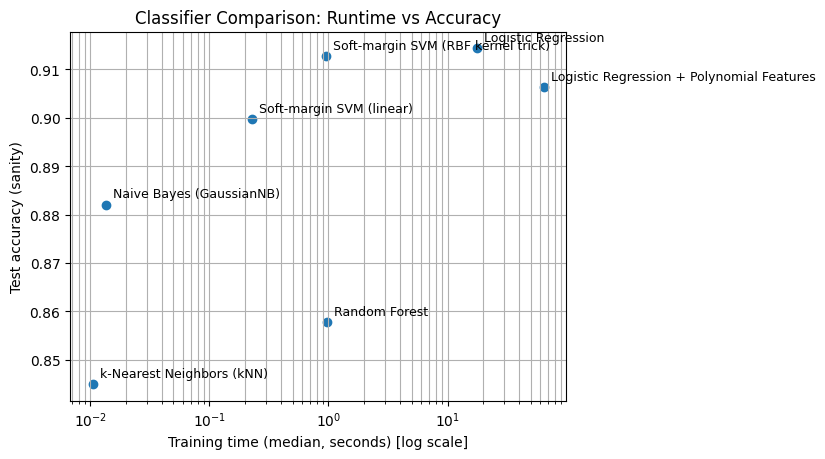

Classifier  Training time (median, s)  \
0                  k-Nearest Neighbors (kNN)                   0.010494   
1                   Naive Bayes (GaussianNB)                   0.013620   
2                   Soft-margin SVM (linear)                   0.229648   
3         Soft-margin SVM (RBF kernel trick)                   0.951355   
4                              Random Forest                   0.974796   
5                        Logistic Regression                  17.708984   
6  Logistic Regression + Polynomial Features                  64.092751   

   Test accuracy (sanity)  
0                0.844911  
1                0.882068  
2                0.899838  
3                0.912763  
4                0.857835  
5                0.914378  
6                0.906300

In [27]:
df = choices_table.copy()

acc_col_candidates = ["Test accuracy (sanity)", "val_acc", "val_acc_best", "Validation accuracy"]
acc_col = next((c for c in acc_col_candidates if c in df.columns), None)
if acc_col is None:
    raise ValueError(f"Could not find an accuracy column in choices_table. Columns: {list(df.columns)}")

df["Training time (median, s)"] = pd.to_numeric(df["Training time (median, s)"], errors="coerce")
df[acc_col] = pd.to_numeric(df[acc_col], errors="coerce")

df_plot = df.dropna(subset=["Training time (median, s)", acc_col]).copy()

df_plot = df_plot.sort_values("Training time (median, s)", ascending=True)

plt.figure()
plt.scatter(df_plot["Training time (median, s)"], df_plot[acc_col])

for _, r in df_plot.iterrows():
    plt.annotate(
        r["Classifier"],
        (r["Training time (median, s)"], r[acc_col]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9
    )

plt.xscale("log") 
plt.xlabel("Training time (median, seconds) [log scale]")
plt.ylabel(acc_col)
plt.title("Classifier Comparison: Runtime vs Accuracy")
plt.grid(True, which="both")
plt.show()

display(df_plot[["Classifier", "Training time (median, s)", acc_col]].reset_index(drop=True))

### 1.2 - Soft-margin Linear SVM from Scratch (Using QP Solver)


In [34]:
class SoftMarginSVMFromScratch:
    
    def __init__(self, C=1.0):
        self.C = C
        self.classes_ = None
        self.models_ = {} 
        self.support_vectors_ = {}
        self.support_vector_indices_ = {}
        
    # solves the dual form of soft-margin SVM using cvxopt QP solver
    def _solve_qp(self, X, y):
        n_samples, n_features = X.shape
        
        # Q_ij = y_i * y_j * (x_i^T * x_j)
        print(f"    Computing kernel matrix ({n_samples}x{n_samples})...")
        K = X @ X.T
        Q = np.outer(y, y) * K
        P = matrix(Q, tc='d')
        q = matrix(-np.ones(n_samples), tc='d')
        
        # inequality constraints
        G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)]), tc='d')
        h = matrix(np.hstack([np.zeros(n_samples), np.ones(n_samples) * self.C]), tc='d')
        
        # equality constraint
        A = matrix(y.reshape(1, -1), tc='d')
        b = matrix(np.zeros(1), tc='d')
        
        print(f"    Solving QP with cvxopt...")
        try:
            solution = solvers.qp(P, q, G, h, A, b)
            
            if solution['status'] != 'optimal':
                print(f"    Warning: solver status is '{solution['status']}'")
            
            alpha_vals = np.array(solution['x']).flatten()
            print(f"    QP solved successfully")
            
        except Exception as e:
            raise ValueError(f"QP solver failed: {str(e)}")
        
        # support vectors, they have non-zero lagrange multipliers
        # but comparing will zero would cause floating point issues, so calculated with a small tolerance
        tolerance = 1e-5
        sv_indices = np.where(alpha_vals > tolerance)[0]
        sv_alphas = alpha_vals[sv_indices]
        sv_X = X[sv_indices]
        sv_y = y[sv_indices]
        
        # w = sum(alpha_i * y_i * x_i) over support vectors
        w = np.sum(sv_alphas[:, np.newaxis] * sv_y[:, np.newaxis] * sv_X, axis=0)
        
        # b = y_i - w^T * x_i
        margin_sv_indices = np.where((alpha_vals > tolerance) & (alpha_vals < self.C - tolerance))[0]
        
        if len(margin_sv_indices) > 0:
            b_values = y[margin_sv_indices] - (X[margin_sv_indices] @ w)
            b = np.mean(b_values)
        else:
            b = np.mean(sv_y - sv_X @ w)
        
        print(f"    Found {len(sv_indices)} support vectors ({len(margin_sv_indices)} on margin)")
        return w, b, sv_indices, alpha_vals
    
    # fit the svm model using one-vs-rest strategy for multi-class classification
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        
        self.classes_ = np.unique(y)
        self.models_ = {}
        self.support_vectors_ = {}
        self.support_vector_indices_ = {}
        
        print(f"Training {len(self.classes_)} binary SVMs (one-vs-rest)...")
        
        for cls in self.classes_:
            print(f"  Training SVM for class {cls}...")
            y_binary = np.where(y == cls, 1, -1)
        
            w, b, sv_indices, alphas = self._solve_qp(X, y_binary)
            
            self.models_[cls] = {'w': w, 'b': b, 'alphas': alphas}
            self.support_vectors_[cls] = X[sv_indices]
            self.support_vector_indices_[cls] = sv_indices
            
            print(f"    Found {len(sv_indices)} support vectors (out of {len(X)} samples)")
        
        return self
    
    def decision_function(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))
        
        for i, cls in enumerate(self.classes_):
            w = self.models_[cls]['w']
            b = self.models_[cls]['b']
            scores[:, i] = X @ w + b
        
        return scores
    
    def predict(self, X):
        scores = self.decision_function(X)
        class_indices = np.argmax(scores, axis=1)
        return self.classes_[class_indices]
    
    def get_support_vectors(self):
        return self.support_vectors_
    
    def get_support_vector_indices(self):
        return self.support_vector_indices_


In [35]:
C_scratch = 0.001  # From the library SVM best result

print("=" * 60)
print("Training Soft-margin Linear SVM from Scratch")
print("=" * 60)

svm_scratch = SoftMarginSVMFromScratch(C=C_scratch)

t0 = time.perf_counter()
svm_scratch.fit(X_train_fused, y_train_enc)
t1 = time.perf_counter()
training_time_scratch = t1 - t0

print(f"\nTraining completed in {training_time_scratch:.2f} seconds")

y_val_pred_scratch = svm_scratch.predict(X_val_fused)
val_acc_scratch = accuracy_score(y_val_enc, y_val_pred_scratch)
print(f"Validation accuracy: {val_acc_scratch:.4f}")

y_test_pred_scratch = svm_scratch.predict(X_test_fused)
test_acc_scratch = accuracy_score(y_test_enc, y_test_pred_scratch)
print(f"Test accuracy: {test_acc_scratch:.4f}")

Training Soft-margin Linear SVM from Scratch
Training 5 binary SVMs (one-vs-rest)...
  Training SVM for class 0...
    Computing kernel matrix (1854x1854)...
    Solving QP with cvxopt...


    QP solved successfully
    Found 536 support vectors (155 on margin)
    Found 536 support vectors (out of 1854 samples)
  Training SVM for class 1...
    Computing kernel matrix (1854x1854)...
    Solving QP with cvxopt...
    QP solved successfully
    Found 659 support vectors (142 on margin)
    Found 659 support vectors (out of 1854 samples)
  Training SVM for class 2...
    Computing kernel matrix (1854x1854)...
    Solving QP with cvxopt...
    QP solved successfully
    Found 613 support vectors (148 on margin)
    Found 613 support vectors (out of 1854 samples)
  Training SVM for class 3...
    Computing kernel matrix (1854x1854)...
    Solving QP with cvxopt...
    QP solved successfully
    Found 532 support vectors (168 on margin)
    Found 532 support vectors (out of 1854 samples)
  Training SVM for class 4...
    Computing kernel matrix (1854x1854)...
    Solving QP with cvxopt...
    QP solved successfully
    Found 594 support vectors (140 on margin)
    Found 594 s

In [36]:
support_vectors_dict = svm_scratch.get_support_vectors()
support_vector_indices_dict = svm_scratch.get_support_vector_indices()

print("Support Vector Statistics:")
print("=" * 60)
total_sv = 0
for cls_idx, cls_name in enumerate(le.classes_):
    sv_count = len(support_vectors_dict[cls_idx])
    total_sv += sv_count
    print(f"Class {cls_name}: {sv_count} support vectors ({sv_count/len(X_train_fused)*100:.2f}% of training data)")

print(f"\nTotal unique support vectors: {len(set().union(*support_vector_indices_dict.values()))}")
print(f"Total support vector instances (across all classes): {total_sv}")


Support Vector Statistics:
Class apple: 536 support vectors (28.91% of training data)
Class banana: 659 support vectors (35.54% of training data)
Class cucumber: 613 support vectors (33.06% of training data)
Class eggplant: 532 support vectors (28.69% of training data)
Class tangerine: 594 support vectors (32.04% of training data)

Total unique support vectors: 1445
Total support vector instances (across all classes): 2934


In [37]:
# distance = (w^T * x + b) / ||w||
def compute_distance_to_hyperplane(X, w, b):
    w_norm = np.linalg.norm(w)
    if w_norm < 1e-10:
        return np.zeros(X.shape[0])
    distances = (X @ w + b) / w_norm
    return distances

farthest_points_dict = {}
farthest_distances_dict = {}
farthest_indices_dict = {}

print("Finding farthest points from hyperplane in each category:")
print("=" * 60)

for cls_idx, cls_name in enumerate(le.classes_):
    w = svm_scratch.models_[cls_idx]['w']
    b = svm_scratch.models_[cls_idx]['b']
    
    class_mask = y_train_enc == cls_idx
    X_class = X_train_fused[class_mask]
    class_indices = np.where(class_mask)[0]
    
    distances = compute_distance_to_hyperplane(X_class, w, b)
    
    n_farthest = min(5, len(distances))
    farthest_local_indices = np.argsort(distances)[-n_farthest:][::-1]
    
    farthest_indices_dict[cls_idx] = class_indices[farthest_local_indices]
    farthest_points_dict[cls_idx] = X_class[farthest_local_indices]
    farthest_distances_dict[cls_idx] = distances[farthest_local_indices]
    
    print(f"Class {cls_name}:")
    print(f"  Farthest {n_farthest} points have distances: {farthest_distances_dict[cls_idx]}")

Finding farthest points from hyperplane in each category:
Class apple:
  Farthest 5 points have distances: [4.65419175 4.58745062 4.5315451  4.33527302 4.28597605]
Class banana:
  Farthest 5 points have distances: [4.31579292 3.67761552 3.63986706 3.54991331 3.54065925]
Class cucumber:
  Farthest 5 points have distances: [4.37103768 4.09461562 4.00541677 3.99426896 3.59026496]
Class eggplant:
  Farthest 5 points have distances: [4.51108231 4.39553783 4.13712023 4.09032161 3.99823332]
Class tangerine:
  Farthest 5 points have distances: [4.58895676 4.48777284 4.35644439 4.07415221 4.07142674]


##### (a) Visual Inspection of Support Vectors


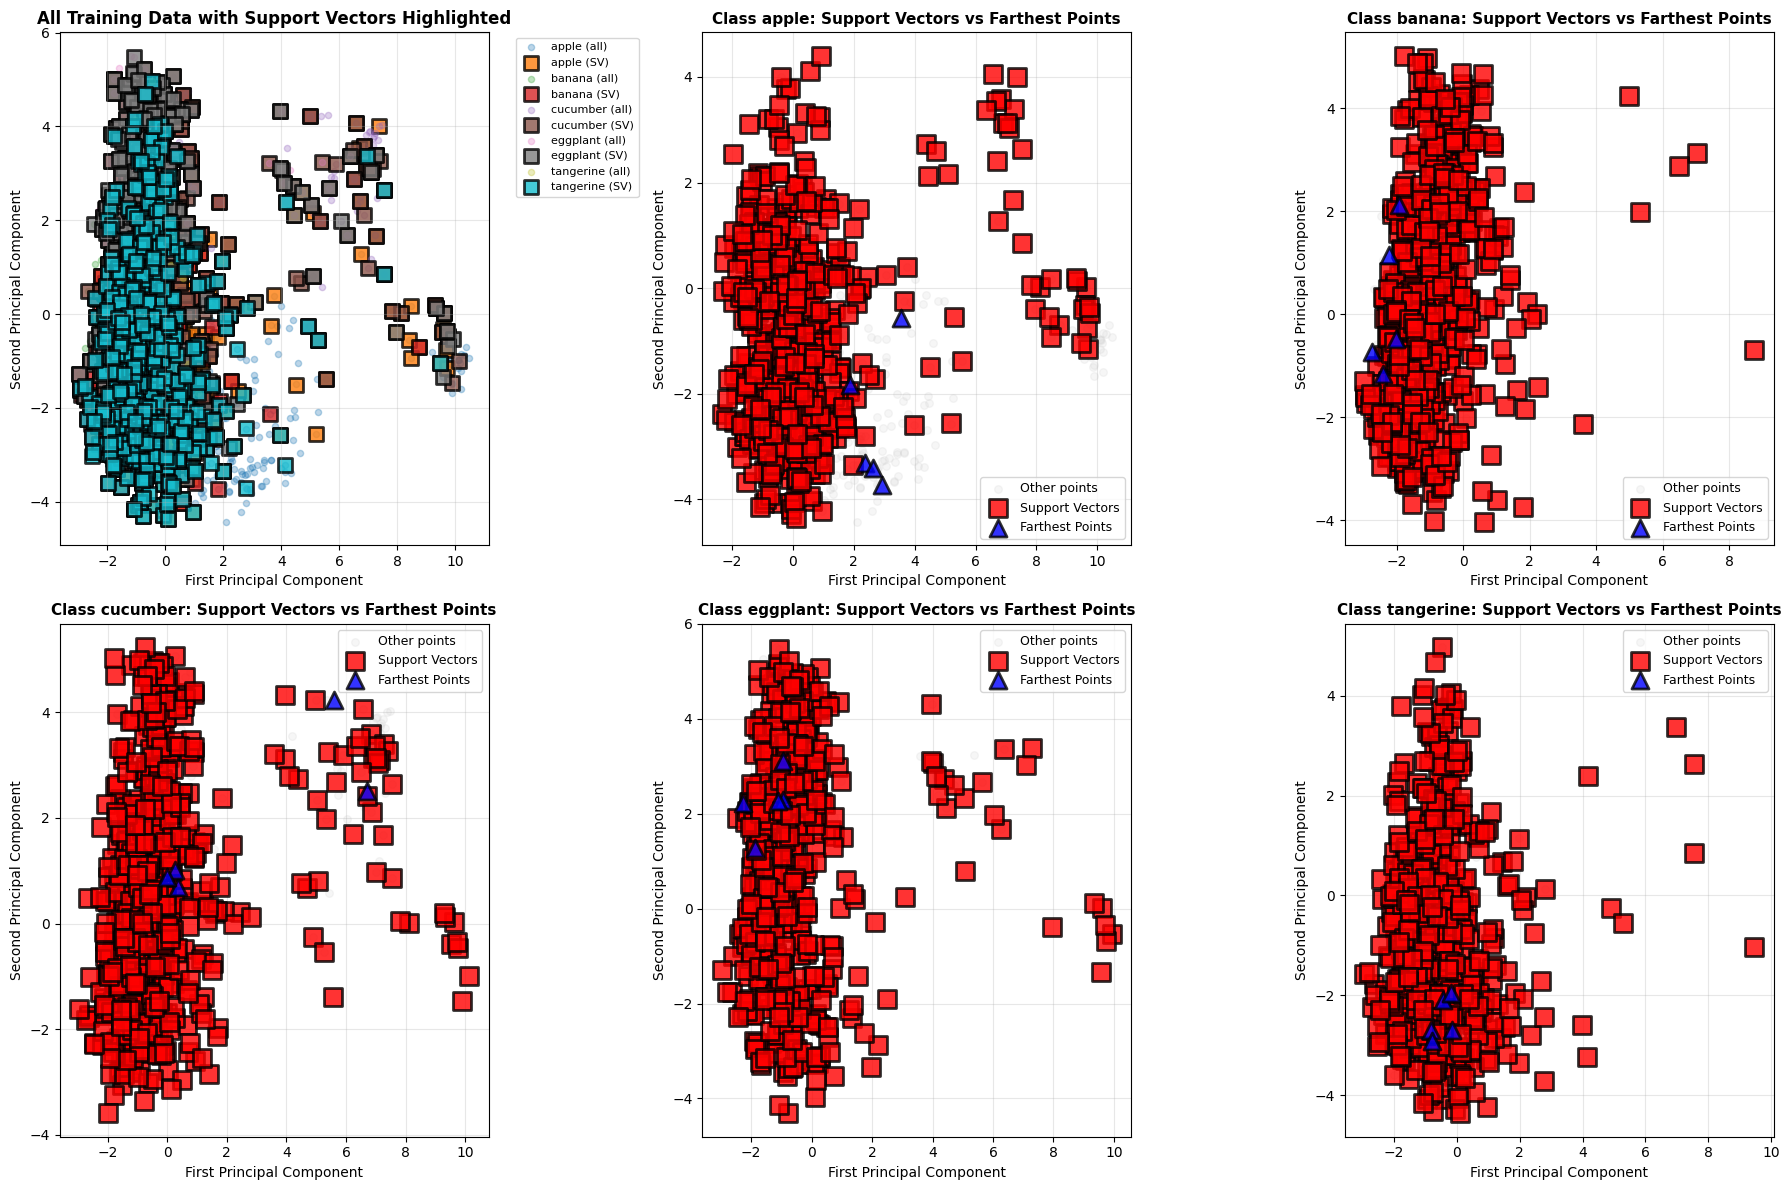

In [38]:
# Fit PCA on training data for visualization
pca_viz = PCA(n_components=2, random_state=42)
X_train_2d = pca_viz.fit_transform(X_train_fused)

# Transform support vectors and farthest points to 2D
sv_2d_dict = {}
farthest_2d_dict = {}

for cls_idx in svm_scratch.classes_:
    sv_2d_dict[cls_idx] = pca_viz.transform(support_vectors_dict[cls_idx])
    farthest_2d_dict[cls_idx] = pca_viz.transform(farthest_points_dict[cls_idx])

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# All training data with support vectors highlighted
ax = axes[0]
for cls_idx, cls_name in enumerate(le.classes_):
    class_mask = y_train_enc == cls_idx
    X_class_2d = X_train_2d[class_mask]
    ax.scatter(X_class_2d[:, 0], X_class_2d[:, 1], alpha=0.3, s=20, 
               label=f'{cls_name} (all)', marker='o')
    
    sv_2d = sv_2d_dict[cls_idx]
    ax.scatter(sv_2d[:, 0], sv_2d[:, 1], s=100, edgecolors='black', 
               linewidths=2, label=f'{cls_name} (SV)', marker='s', alpha=0.8)

ax.set_title('All Training Data with Support Vectors Highlighted', fontsize=12, fontweight='bold')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# Individual class plots showing support vectors vs farthest points
for plot_idx, cls_idx in enumerate(svm_scratch.classes_, start=1):
    ax = axes[plot_idx]
    cls_name = le.classes_[cls_idx]
    
    # All points of this class
    class_mask = y_train_enc == cls_idx
    X_class_2d = X_train_2d[class_mask]
    ax.scatter(X_class_2d[:, 0], X_class_2d[:, 1], alpha=0.2, s=30, 
               c='lightgray', label='Other points', marker='o')
    
    # Support vectors
    sv_2d = sv_2d_dict[cls_idx]
    ax.scatter(sv_2d[:, 0], sv_2d[:, 1], s=150, c='red', edgecolors='black', 
               linewidths=2, label='Support Vectors', marker='s', alpha=0.8, zorder=5)
    
    # Farthest points
    farthest_2d = farthest_2d_dict[cls_idx]
    ax.scatter(farthest_2d[:, 0], farthest_2d[:, 1], s=150, c='blue', 
               edgecolors='black', linewidths=2, label='Farthest Points', 
               marker='^', alpha=0.8, zorder=5)
    
    ax.set_title(f'Class {cls_name}: Support Vectors vs Farthest Points', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Compare support vectors and farthest points
print("=" * 60)
print("Statistical Comparison: Support Vectors vs Farthest Points")
print("=" * 60)

for cls_idx, cls_name in enumerate(le.classes_):
    sv = support_vectors_dict[cls_idx]
    farthest = farthest_points_dict[cls_idx]
    
    sv_mean = np.mean(sv, axis=0)
    sv_std = np.std(sv, axis=0)
    farthest_mean = np.mean(farthest, axis=0)
    farthest_std = np.std(farthest, axis=0)
    
    sv_norm = np.mean(np.linalg.norm(sv, axis=1))
    farthest_norm = np.mean(np.linalg.norm(farthest, axis=1))
    
    print(f"\nClass {cls_name}:")
    print(f"  Support vectors:")
    print(f"    Count: {len(sv)}")
    print(f"    Avg norm: {sv_norm:.4f}")
    print(f"    Feature mean range: [{np.min(sv_mean):.4f}, {np.max(sv_mean):.4f}]")
    print(f"  Farthest points:")
    print(f"    Count: {len(farthest)}")
    print(f"    Avg norm: {farthest_norm:.4f}")
    print(f"    Feature mean range: [{np.min(farthest_mean):.4f}, {np.max(farthest_mean):.4f}]")
    
    w = svm_scratch.models_[cls_idx]['w']
    b = svm_scratch.models_[cls_idx]['b']
    
    sv_distances = np.abs(compute_distance_to_hyperplane(sv, w, b))
    farthest_distances_abs = np.abs(compute_distance_to_hyperplane(farthest, w, b))
    
    print(f"    Avg distance to hyperplane (SV): {np.mean(sv_distances):.4f}")
    print(f"    Avg distance to hyperplane (Farthest): {np.mean(farthest_distances_abs):.4f}")


Statistical Comparison: Support Vectors vs Farthest Points

Class apple:
  Support vectors:
    Count: 536
    Avg norm: 18.3388
    Feature mean range: [-0.2240, 1.4554]
  Farthest points:
    Count: 5
    Avg norm: 19.5612
    Feature mean range: [-1.2636, 6.2852]
    Avg distance to hyperplane (SV): 1.4276
    Avg distance to hyperplane (Farthest): 4.4789

Class banana:
  Support vectors:
    Count: 659
    Avg norm: 17.9124
    Feature mean range: [-0.2186, 1.9630]
  Farthest points:
    Count: 5
    Avg norm: 18.4085
    Feature mean range: [-1.4322, 5.6555]
    Avg distance to hyperplane (SV): 1.1855
    Avg distance to hyperplane (Farthest): 3.7448

Class cucumber:
  Support vectors:
    Count: 613
    Avg norm: 17.9362
    Feature mean range: [-0.2163, 1.7370]
  Farthest points:
    Count: 5
    Avg norm: 17.6026
    Feature mean range: [-1.2837, 3.1791]
    Avg distance to hyperplane (SV): 1.3092
    Avg distance to hyperplane (Farthest): 4.0111

Class eggplant:
  Support vect

##### (b) Distance Analysis Between Support Vectors Across Classes


In [40]:
# Compute pairwise distances between support vectors of different classes
print("=" * 60)
print("Pairwise Distance Analysis: Support Vectors Across Classes")
print("=" * 60)

# For each pair of classes, compute distances between their UNIQUE support vectors
class_pairs = []
min_distances = []
mean_distances = []
overlap_counts = []

for i, cls_i in enumerate(svm_scratch.classes_):
    for j, cls_j in enumerate(svm_scratch.classes_):
        if i < j:  
            sv_indices_i = set(support_vector_indices_dict[cls_i])
            sv_indices_j = set(support_vector_indices_dict[cls_j])
            
            overlap = sv_indices_i.intersection(sv_indices_j)
            overlap_counts.append(len(overlap))
            
            unique_sv_i = list(sv_indices_i - overlap)
            unique_sv_j = list(sv_indices_j - overlap)
            
            if len(unique_sv_i) > 0 and len(unique_sv_j) > 0:
                X_sv_i = X_train_fused[unique_sv_i]
                X_sv_j = X_train_fused[unique_sv_j]
                
                distances_ij = []
                for x_i in X_sv_i:
                    for x_j in X_sv_j:
                        distances_ij.append(np.linalg.norm(x_i - x_j))
                
                distances_ij = np.array(distances_ij)
                min_dist = np.min(distances_ij)
                mean_dist = np.mean(distances_ij)
            else:
                min_dist = np.nan
                mean_dist = np.nan
            
            class_pairs.append((le.classes_[cls_i], le.classes_[cls_j]))
            min_distances.append(min_dist)
            mean_distances.append(mean_dist)

distance_df = pd.DataFrame({
    'Class_1': [p[0] for p in class_pairs],
    'Class_2': [p[1] for p in class_pairs],
    'Min_Distance': min_distances,
    'Mean_Distance': mean_distances,
    'Overlapping_SVs': overlap_counts
})

distance_df_valid = distance_df.dropna(subset=['Min_Distance']).copy()

if len(distance_df_valid) > 0:
    distance_df_valid = distance_df_valid.sort_values('Min_Distance', ascending=True)
    print("\nPairwise distances between UNIQUE support vectors (sorted by minimum distance):")
    print(distance_df_valid.to_string(index=False))
else:
    print("\nWarning: All support vectors overlap between classes (OvR artifact)")
    print("Showing raw data with overlaps:")
    print(distance_df.to_string(index=False))

Pairwise Distance Analysis: Support Vectors Across Classes



Pairwise distances between UNIQUE support vectors (sorted by minimum distance):
 Class_1   Class_2  Min_Distance  Mean_Distance  Overlapping_SVs
  banana  eggplant     11.665499      24.985636              231
  banana tangerine     12.147846      24.977890              224
   apple    banana     13.244451      25.026804              148
   apple tangerine     13.524614      25.297206              243
cucumber tangerine     13.617408      24.828167              188
   apple  cucumber     14.235443      24.977769              171
cucumber  eggplant     14.487837      25.031636              202
   apple  eggplant     14.768054      25.233336              137
eggplant tangerine     15.109777      25.098992              157
  banana  cucumber     16.052370      25.006535              268


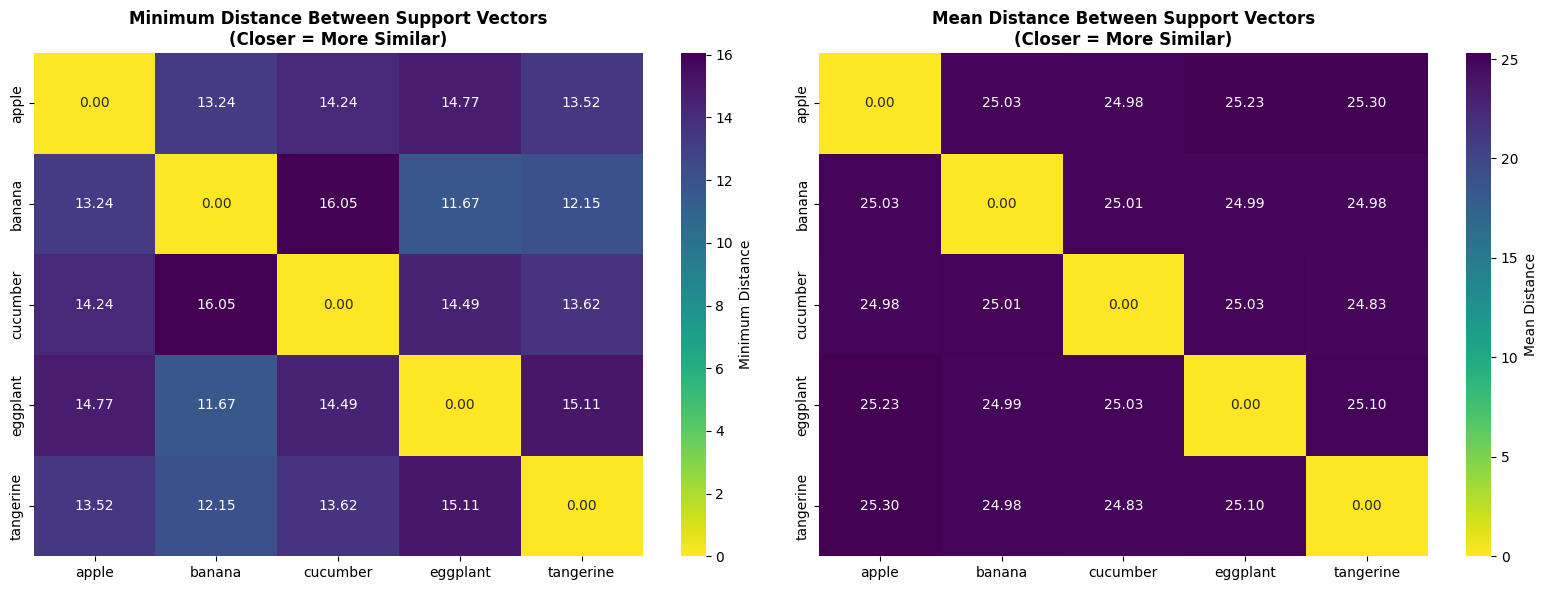

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap of minimum distances
ax1 = axes[0]
distance_matrix_min = np.zeros((len(le.classes_), len(le.classes_)))
distance_matrix_mean = np.zeros((len(le.classes_), len(le.classes_)))

for idx, (cls_i, cls_j, min_d, mean_d) in enumerate(zip(
    distance_df['Class_1'], distance_df['Class_2'], 
    distance_df['Min_Distance'], distance_df['Mean_Distance']
)):
    i = np.where(le.classes_ == cls_i)[0][0]
    j = np.where(le.classes_ == cls_j)[0][0]
    distance_matrix_min[i, j] = min_d
    distance_matrix_min[j, i] = min_d
    distance_matrix_mean[i, j] = mean_d
    distance_matrix_mean[j, i] = mean_d

sns.heatmap(distance_matrix_min, annot=True, fmt='.2f', cmap='viridis_r',
            xticklabels=le.classes_, yticklabels=le.classes_,
            ax=ax1, cbar_kws={'label': 'Minimum Distance'})
ax1.set_title('Minimum Distance Between Support Vectors\n(Closer = More Similar)', 
              fontsize=12, fontweight='bold')

# Heatmap of mean distances
ax2 = axes[1]
sns.heatmap(distance_matrix_mean, annot=True, fmt='.2f', cmap='viridis_r',
            xticklabels=le.classes_, yticklabels=le.classes_,
            ax=ax2, cbar_kws={'label': 'Mean Distance'})
ax2.set_title('Mean Distance Between Support Vectors\n(Closer = More Similar)', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [42]:
# Compare with confusion matrix to see if closest support vectors correspond to most confused classes
print("=" * 60)
print("Comparing Support Vector Distances with Classification Confusion")
print("=" * 60)

cm = confusion_matrix(y_test_enc, y_test_pred_scratch, labels=svm_scratch.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Find most confused pairs
confusion_pairs = []
confusion_scores = []

for i, cls_i in enumerate(svm_scratch.classes_):
    for j, cls_j in enumerate(svm_scratch.classes_):
        if i != j:
            confusion_pairs.append((le.classes_[cls_i], le.classes_[cls_j]))
            confusion_scores.append(cm_normalized[i, j])

confusion_df = pd.DataFrame({
    'Class_1': [p[0] for p in confusion_pairs],
    'Class_2': [p[1] for p in confusion_pairs],
    'Confusion_Rate': confusion_scores
})

if len(distance_df_valid) > 0:
    comparison_df = distance_df_valid.copy()
else:
    comparison_df = distance_df.copy()

comparison_df['Confusion_Rate'] = 0.0

for idx, row in comparison_df.iterrows():
    mask1 = (confusion_df['Class_1'] == row['Class_1']) & (confusion_df['Class_2'] == row['Class_2'])
    mask2 = (confusion_df['Class_1'] == row['Class_2']) & (confusion_df['Class_2'] == row['Class_1'])
    mask = mask1 | mask2
    
    if mask.any():
        confusion_rate = confusion_df.loc[mask, 'Confusion_Rate'].max()
        comparison_df.at[idx, 'Confusion_Rate'] = confusion_rate

comparison_df = comparison_df.sort_values('Min_Distance', ascending=True)
print("\nSupport Vector Distance vs Classification Confusion:")
print(comparison_df.to_string(index=False))

# Compute correlation
if len(comparison_df) > 1 and comparison_df['Min_Distance'].std() > 0:
    correlation = np.corrcoef(comparison_df['Min_Distance'], comparison_df['Confusion_Rate'])[0, 1]
    print(f"\nCorrelation between minimum SV distance and confusion rate: {correlation:.4f}")
    
    # Check for negative correlation
    if not np.isnan(correlation):
        if correlation < -0.3:
            print("  → Strong negative correlation: Closer support vectors ARE associated with more confusion")
        elif correlation > 0.3:
            print("  → Positive correlation: Farther support vectors are associated with more confusion")
        else:
            print("  → Weak correlation: Limited relationship between SV distance and confusion")
else:
    print("\nCannot compute correlation: Insufficient variance in distances")
    print(f"  Distance std: {comparison_df['Min_Distance'].std():.6f}")


Comparing Support Vector Distances with Classification Confusion

Support Vector Distance vs Classification Confusion:
 Class_1   Class_2  Min_Distance  Mean_Distance  Overlapping_SVs  Confusion_Rate
  banana  eggplant     11.665499      24.985636              231        0.040984
  banana tangerine     12.147846      24.977890              224        0.074380
   apple    banana     13.244451      25.026804              148        0.015267
   apple tangerine     13.524614      25.297206              243        0.038168
cucumber tangerine     13.617408      24.828167              188        0.049180
   apple  cucumber     14.235443      24.977769              171        0.038168
cucumber  eggplant     14.487837      25.031636              202        0.032787
   apple  eggplant     14.768054      25.233336              137        0.016393
eggplant tangerine     15.109777      25.098992              157        0.024590
  banana  cucumber     16.052370      25.006535              268       

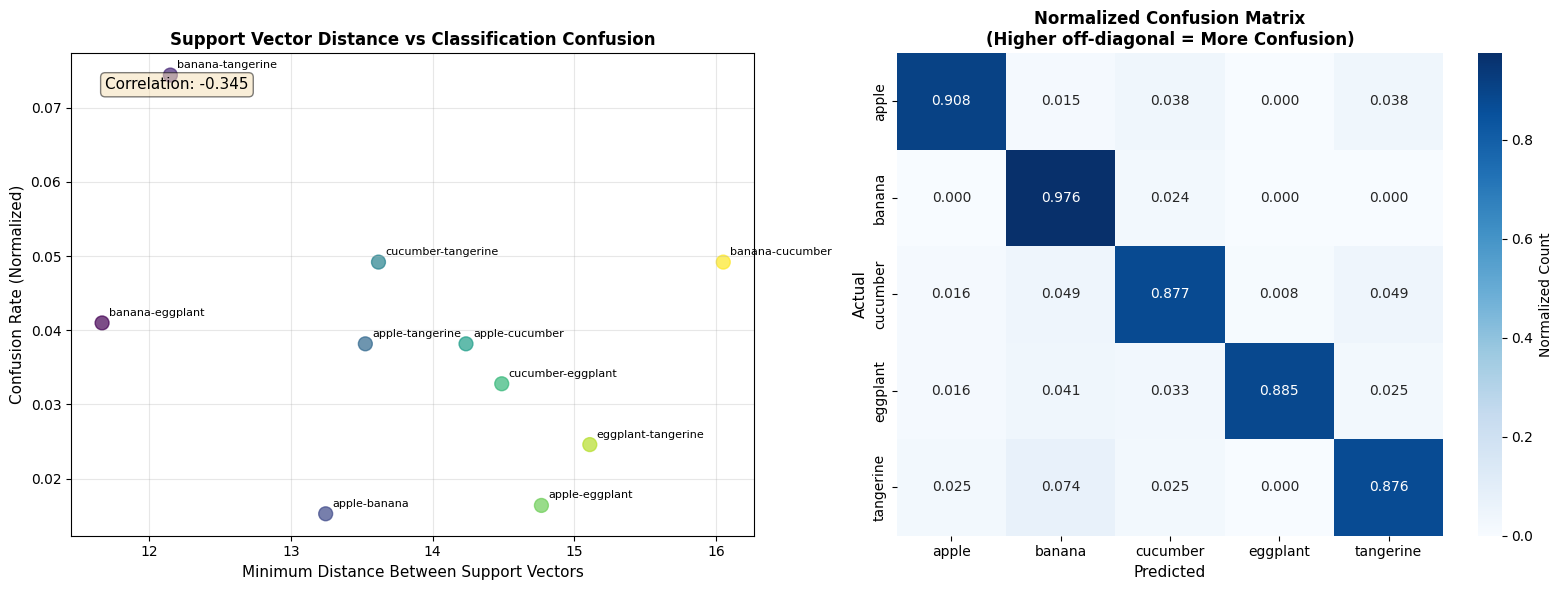

In [43]:
# Visualize the relationship
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot of distance vs confusion
ax1 = axes[0]
scatter = ax1.scatter(comparison_df['Min_Distance'], comparison_df['Confusion_Rate'], 
                     s=100, alpha=0.7, c=range(len(comparison_df)), cmap='viridis')

for idx, row in comparison_df.iterrows():
    label = f"{row['Class_1']}-{row['Class_2']}"
    ax1.annotate(label, (row['Min_Distance'], row['Confusion_Rate']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax1.set_xlabel('Minimum Distance Between Support Vectors', fontsize=11)
ax1.set_ylabel('Confusion Rate (Normalized)', fontsize=11)
ax1.set_title('Support Vector Distance vs Classification Confusion', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Confusion matrix
ax2 = axes[1]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            ax=ax2, cbar_kws={'label': 'Normalized Count'})
ax2.set_title('Normalized Confusion Matrix\n(Higher off-diagonal = More Confusion)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=11)
ax2.set_ylabel('Actual', fontsize=11)

plt.tight_layout()
plt.show()


In [44]:
# Rank the pairs by minimum distance
print("=" * 60)
print("Ranking of Class Pairs by Support Vector Proximity")
print("=" * 60)

ranked_pairs = comparison_df.copy()
ranked_pairs['Rank'] = range(1, len(ranked_pairs) + 1)
ranked_pairs = ranked_pairs[['Rank', 'Class_1', 'Class_2', 'Min_Distance', 'Confusion_Rate']]

print("\nTop 5 Closest Support Vector Pairs:")
print(ranked_pairs.head(5).to_string(index=False))

print("\nTop 5 Most Confused Class Pairs:")
top_confused = comparison_df.nlargest(5, 'Confusion_Rate')[['Class_1', 'Class_2', 'Min_Distance', 'Confusion_Rate']]
print(top_confused.to_string(index=False))

top5_closest_classes = set()
for _, row in ranked_pairs.head(5).iterrows():
    top5_closest_classes.add(row['Class_1'])
    top5_closest_classes.add(row['Class_2'])

top5_confused_classes = set()
for _, row in top_confused.iterrows():
    top5_confused_classes.add(row['Class_1'])
    top5_confused_classes.add(row['Class_2'])

overlap = top5_closest_classes.intersection(top5_confused_classes)
print(f"\nClass overlap between top 5 closest SV pairs and top 5 confused pairs: {overlap}")


Ranking of Class Pairs by Support Vector Proximity

Top 5 Closest Support Vector Pairs:
 Rank  Class_1   Class_2  Min_Distance  Confusion_Rate
    1   banana  eggplant     11.665499        0.040984
    2   banana tangerine     12.147846        0.074380
    3    apple    banana     13.244451        0.015267
    4    apple tangerine     13.524614        0.038168
    5 cucumber tangerine     13.617408        0.049180

Top 5 Most Confused Class Pairs:
 Class_1   Class_2  Min_Distance  Confusion_Rate
  banana tangerine     12.147846        0.074380
cucumber tangerine     13.617408        0.049180
  banana  cucumber     16.052370        0.049180
  banana  eggplant     11.665499        0.040984
   apple tangerine     13.524614        0.038168

Class overlap between top 5 closest SV pairs and top 5 confused pairs: {np.str_('eggplant'), np.str_('banana'), np.str_('cucumber'), np.str_('tangerine'), np.str_('apple')}


### 1.4 - Outlier Detection Using SVM Constraints


In [45]:
# Distance = (w^T * x + b) / ||w||
def compute_distance_to_decision_boundary(X, svm_model):
    decision_scores = svm_model.decision_function(X)
    predicted_classes = np.argmax(decision_scores, axis=1)
    
    distances = np.zeros(len(X))
    for i, (x, pred_cls) in enumerate(zip(X, predicted_classes)):
        w = svm_model.models_[pred_cls]['w']
        b = svm_model.models_[pred_cls]['b']
        w_norm = np.linalg.norm(w)
        if w_norm > 1e-10:
            distances[i] = (x @ w + b) / w_norm
    
    return distances, predicted_classes

distances, predictions = compute_distance_to_decision_boundary(X_train_fused, svm_scratch)

print("Distance Statistics:")
print(f"  Mean: {np.mean(distances):.4f}")
print(f"  Std:  {np.std(distances):.4f}")
print(f"  Min:  {np.min(distances):.4f}")
print(f"  Max:  {np.max(distances):.4f}")


Distance Statistics:
  Mean: 1.2535
  Std:  1.2792
  Min:  -1.6904
  Max:  4.6542


In [46]:
# Compute Z-scores for distances
# Outliers: points with unusual distances
z_scores = (distances - np.mean(distances)) / (np.std(distances) + 1e-10)

# Detect outliers using |z-score| > threshold
z_threshold = 2
is_outlier = np.abs(z_scores) > z_threshold

n_outliers = np.sum(is_outlier)
print(f"\nOutlier Detection (|z-score| > {z_threshold}):")
print(f"  Detected: {n_outliers} / {len(X_train_fused)} ({100*n_outliers/len(X_train_fused):.2f}%)")

low_distance_outliers = (z_scores < -z_threshold).sum()
high_distance_outliers = (z_scores > z_threshold).sum()
print(f"  Low distance (near boundary): {low_distance_outliers}")
print(f"  High distance (far from boundary): {high_distance_outliers}")

print(f"\nOutliers per class:")
for cls_idx, cls_name in enumerate(le.classes_):
    mask = y_train_enc == cls_idx
    n_cls_outliers = np.sum(is_outlier[mask])
    print(f"  {cls_name}: {n_cls_outliers} / {mask.sum()} ({100*n_cls_outliers/mask.sum():.1f}%)")


Outlier Detection (|z-score| > 2):
  Detected: 51 / 1854 (2.75%)
  Low distance (near boundary): 19
  High distance (far from boundary): 32

Outliers per class:
  apple: 15 / 394 (3.8%)
  banana: 4 / 368 (1.1%)
  cucumber: 8 / 364 (2.2%)
  eggplant: 13 / 364 (3.6%)
  tangerine: 11 / 364 (3.0%)


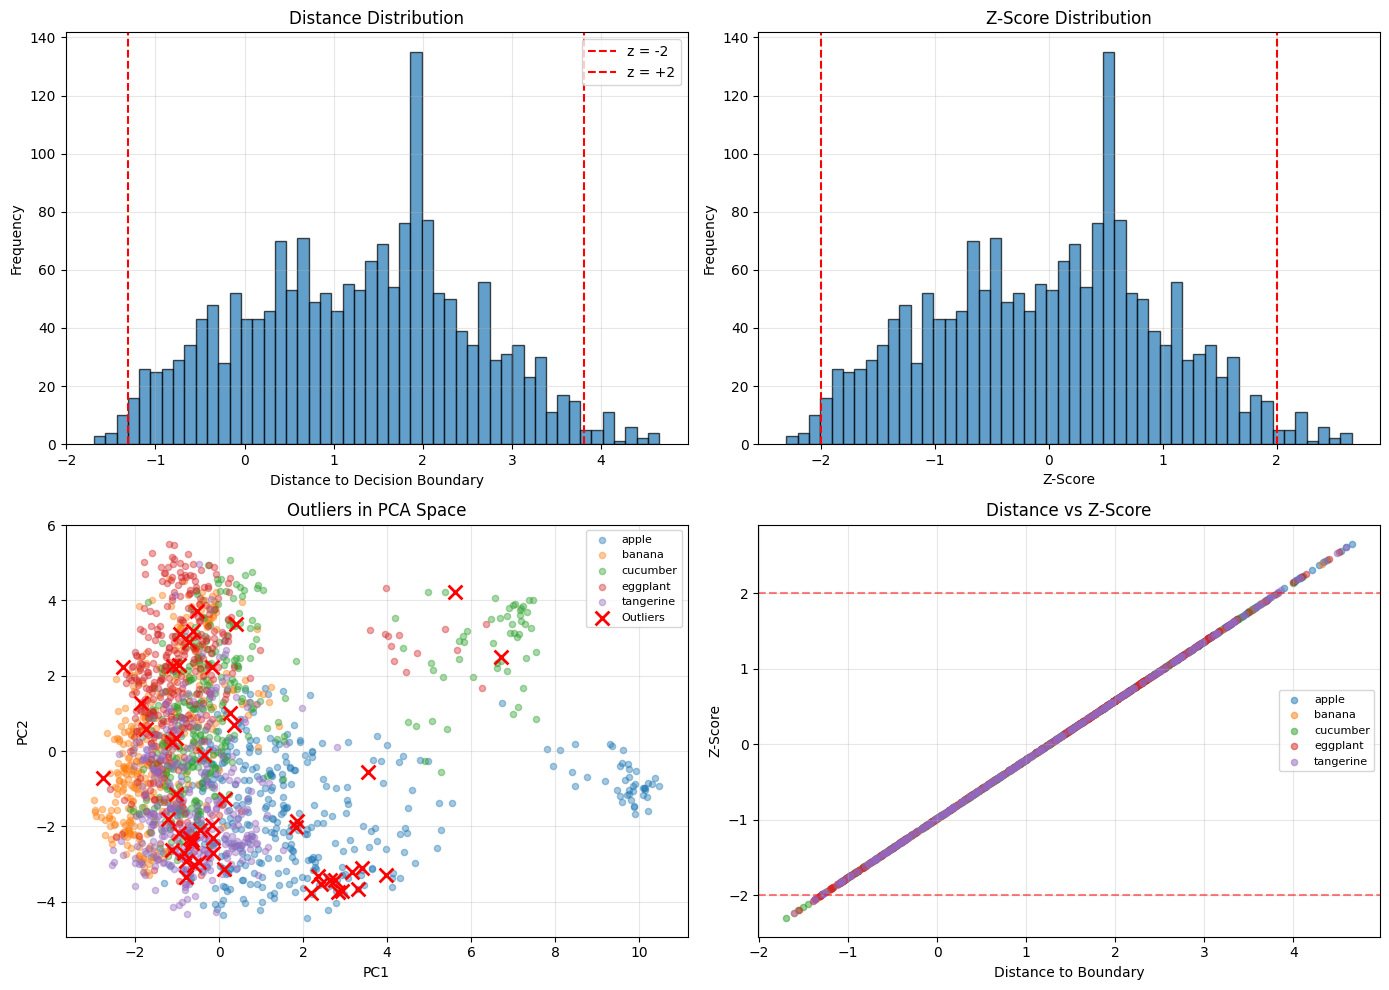

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distance distribution with z-score thresholds
ax = axes[0, 0]
ax.hist(distances, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(np.mean(distances) - z_threshold*np.std(distances), color='red', 
           linestyle='--', label=f'z = -{z_threshold}')
ax.axvline(np.mean(distances) + z_threshold*np.std(distances), color='red', 
           linestyle='--', label=f'z = +{z_threshold}')
ax.set_xlabel('Distance to Decision Boundary')
ax.set_ylabel('Frequency')
ax.set_title('Distance Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Z-score distribution
ax = axes[0, 1]
ax.hist(z_scores, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(-z_threshold, color='red', linestyle='--')
ax.axvline(z_threshold, color='red', linestyle='--')
ax.set_xlabel('Z-Score')
ax.set_ylabel('Frequency')
ax.set_title('Z-Score Distribution')
ax.grid(True, alpha=0.3)

# PCA visualization with outliers
ax = axes[1, 0]
for cls_idx, cls_name in enumerate(le.classes_):
    mask = (y_train_enc == cls_idx) & ~is_outlier
    ax.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], 
              alpha=0.4, s=20, label=cls_name)
ax.scatter(X_train_2d[is_outlier, 0], X_train_2d[is_outlier, 1],
          c='red', marker='x', s=100, linewidths=2, label='Outliers', zorder=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Outliers in PCA Space')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Distance vs Z-score for each class
ax = axes[1, 1]
for cls_idx, cls_name in enumerate(le.classes_):
    mask = y_train_enc == cls_idx
    ax.scatter(distances[mask], z_scores[mask], alpha=0.5, s=20, label=cls_name)
ax.axhline(-z_threshold, color='red', linestyle='--', alpha=0.5)
ax.axhline(z_threshold, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Distance to Boundary')
ax.set_ylabel('Z-Score')
ax.set_title('Distance vs Z-Score')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [48]:
# Analyze top outliers
print("\nTop 10 Outliers (by absolute z-score):")
top_outlier_idx = np.argsort(np.abs(z_scores))[-10:][::-1]

for i, idx in enumerate(top_outlier_idx, 1):
    true_cls = le.classes_[y_train_enc[idx]]
    pred_cls = le.classes_[predictions[idx]]
    print(f"{i}. Index={idx}, z={z_scores[idx]:.2f}, dist={distances[idx]:.2f}, "
          f"true={true_cls}, pred={pred_cls}, "
          f"{'✓' if true_cls==pred_cls else '✗'}")

outlier_correct = (y_train_enc[is_outlier] == predictions[is_outlier]).sum()
normal_correct = (y_train_enc[~is_outlier] == predictions[~is_outlier]).sum()

print(f"\nClassification Accuracy:")
print(f"  Outliers: {outlier_correct}/{is_outlier.sum()} = {100*outlier_correct/is_outlier.sum():.1f}%")
print(f"  Normal:   {normal_correct}/{(~is_outlier).sum()} = {100*normal_correct/(~is_outlier).sum():.1f}%")



Top 10 Outliers (by absolute z-score):
1. Index=1174, z=2.66, dist=4.65, true=apple, pred=apple, ✓
2. Index=811, z=2.61, dist=4.59, true=tangerine, pred=tangerine, ✓
3. Index=1497, z=2.61, dist=4.59, true=apple, pred=apple, ✓
4. Index=637, z=2.56, dist=4.53, true=apple, pred=apple, ✓
5. Index=1700, z=2.55, dist=4.51, true=eggplant, pred=eggplant, ✓
6. Index=1462, z=2.53, dist=4.49, true=tangerine, pred=tangerine, ✓
7. Index=1677, z=2.46, dist=4.40, true=eggplant, pred=eggplant, ✓
8. Index=1682, z=2.44, dist=4.37, true=cucumber, pred=cucumber, ✓
9. Index=1657, z=2.43, dist=4.36, true=tangerine, pred=tangerine, ✓
10. Index=679, z=2.41, dist=4.34, true=apple, pred=apple, ✓

Classification Accuracy:
  Outliers: 41/51 = 80.4%
  Normal:   1723/1803 = 95.6%



Displaying Top 20 Outlier Images:


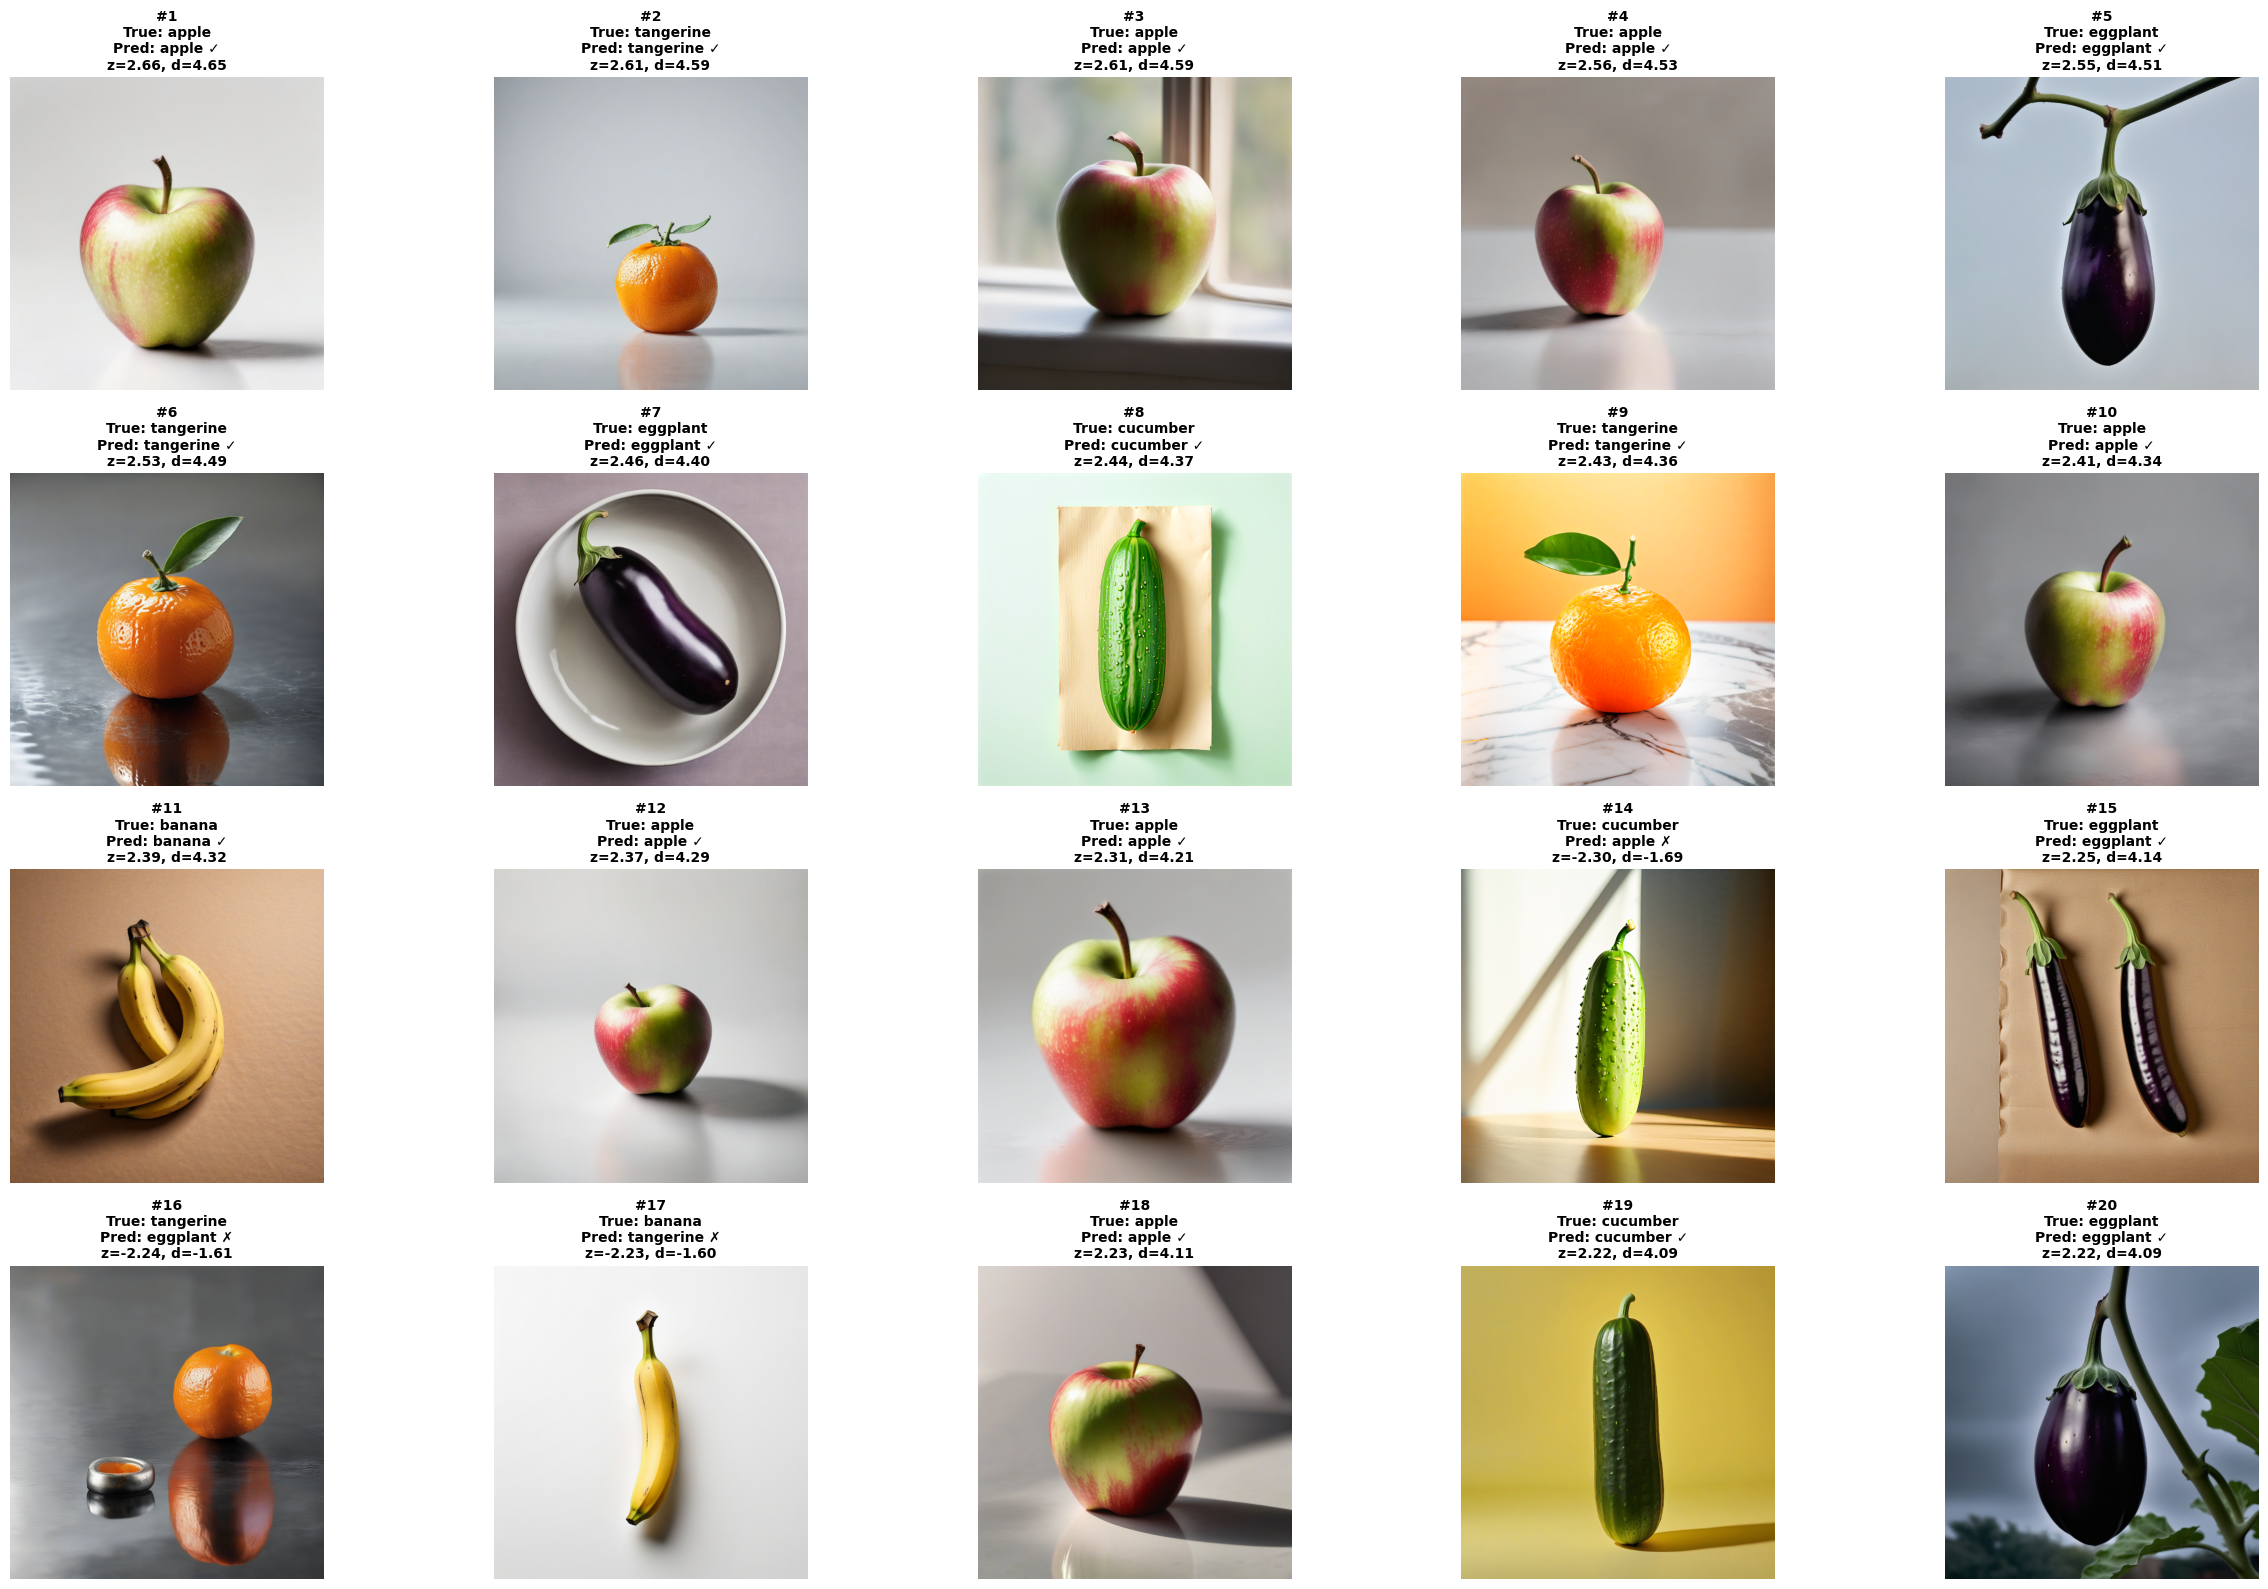


Image display complete!


In [49]:
print("\nDisplaying Top 20 Outlier Images:")
print("=" * 60)

top_20_idx = np.argsort(np.abs(z_scores))[-20:][::-1]

fig, axes = plt.subplots(4, 5, figsize=(25, 16))

for plot_idx, data_idx in enumerate(top_20_idx):
    row = plot_idx // 5
    col = plot_idx % 5
    ax = axes[row, col]

    img_path = p_train[data_idx]
    
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    true_cls = le.classes_[y_train_enc[data_idx]]
    pred_cls = le.classes_[predictions[data_idx]]
    z_score = z_scores[data_idx]
    distance = distances[data_idx]
    
    ax.imshow(img_rgb)
    ax.axis('off')
    
    status = '✓' if true_cls == pred_cls else '✗'
    title = f"#{plot_idx+1}\n"
    title += f"True: {true_cls}\n"
    title += f"Pred: {pred_cls} {status}\n"
    title += f"z={z_score:.2f}, d={distance:.2f}"
    ax.set_title(title, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nImage display complete!")



Displaying Outliers by Type:


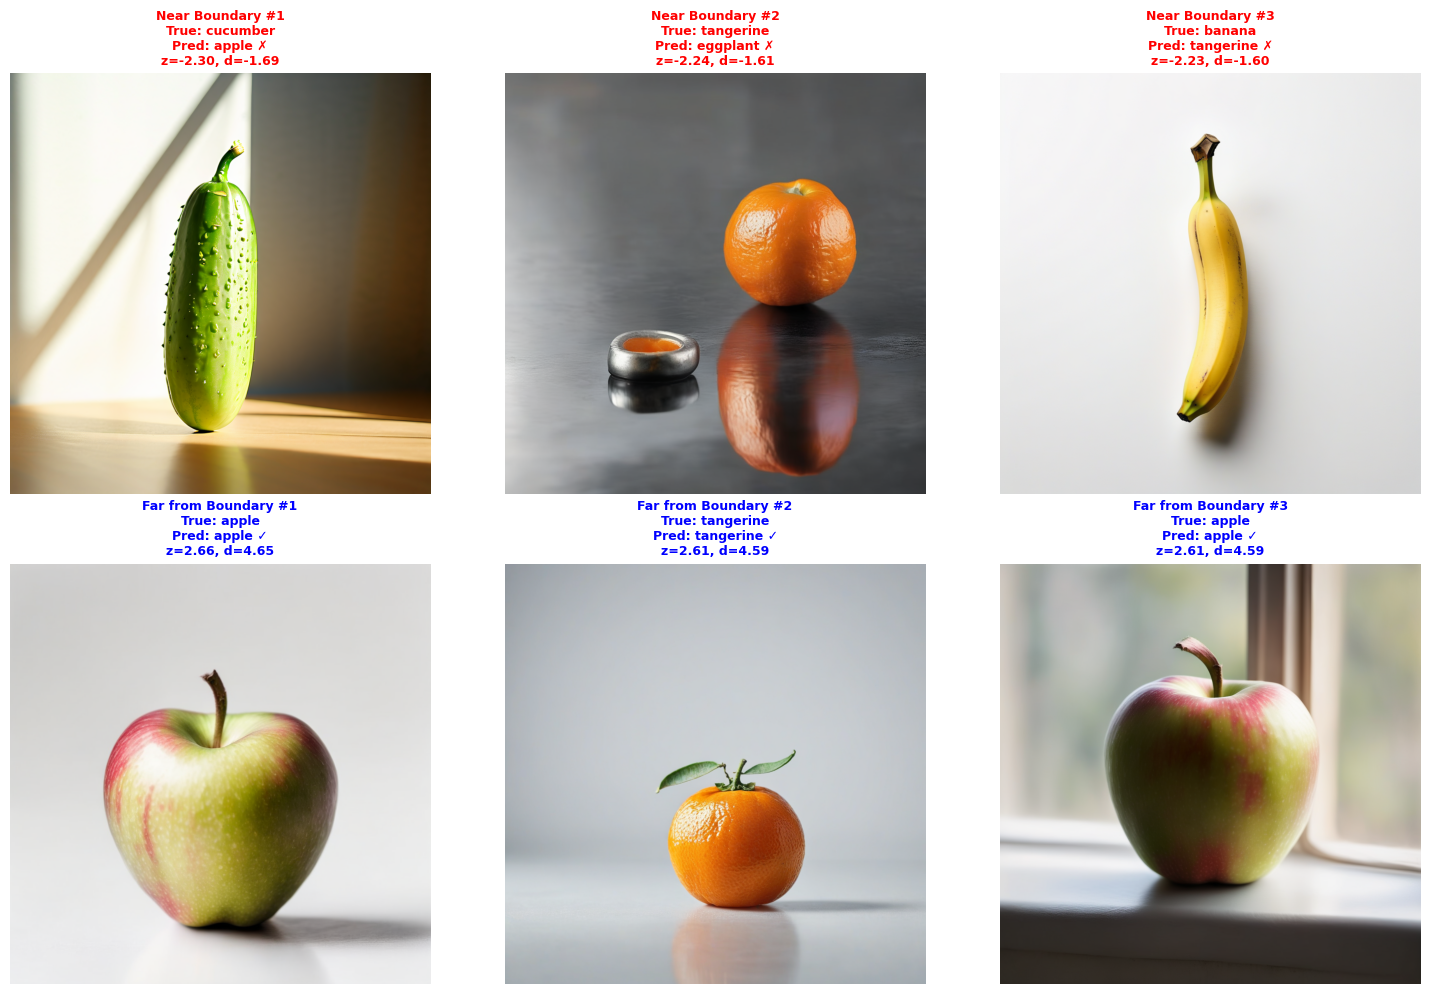


Showing 3 near-boundary and 3 far-boundary outliers


In [50]:
print("\nDisplaying Outliers by Type:")
print("=" * 60)

# Get top 3 low-distance outliers
low_dist_outliers = np.where(z_scores < -z_threshold)[0]
if len(low_dist_outliers) > 0:
    low_dist_sorted = low_dist_outliers[np.argsort(z_scores[low_dist_outliers])][:3]
else:
    low_dist_sorted = []

# Get top 3 high-distance outliers 
high_dist_outliers = np.where(z_scores > z_threshold)[0]
if len(high_dist_outliers) > 0:
    high_dist_sorted = high_dist_outliers[np.argsort(-z_scores[high_dist_outliers])][:3]
else:
    high_dist_sorted = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Low distance outliers (near boundary)
for col in range(3):
    ax = axes[0, col]
    if col < len(low_dist_sorted):
        data_idx = low_dist_sorted[col]
        img_path = p_train[data_idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        true_cls = le.classes_[y_train_enc[data_idx]]
        pred_cls = le.classes_[predictions[data_idx]]
        z_score = z_scores[data_idx]
        distance = distances[data_idx]
        
        ax.imshow(img_rgb)
        status = '✓' if true_cls == pred_cls else '✗'
        title = f"Near Boundary #{col+1}\n"
        title += f"True: {true_cls}\n"
        title += f"Pred: {pred_cls} {status}\n"
        title += f"z={z_score:.2f}, d={distance:.2f}"
        ax.set_title(title, fontsize=9, fontweight='bold', color='red')
    else:
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
    ax.axis('off')

# Row 2: High distance outliers (far from boundary)
for col in range(3):
    ax = axes[1, col]
    if col < len(high_dist_sorted):
        data_idx = high_dist_sorted[col]
        img_path = p_train[data_idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        true_cls = le.classes_[y_train_enc[data_idx]]
        pred_cls = le.classes_[predictions[data_idx]]
        z_score = z_scores[data_idx]
        distance = distances[data_idx]
        
        ax.imshow(img_rgb)
        status = '✓' if true_cls == pred_cls else '✗'
        title = f"Far from Boundary #{col+1}\n"
        title += f"True: {true_cls}\n"
        title += f"Pred: {pred_cls} {status}\n"
        title += f"z={z_score:.2f}, d={distance:.2f}"
        ax.set_title(title, fontsize=9, fontweight='bold', color='blue')
    else:
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nShowing {len(low_dist_sorted)} near-boundary and {len(high_dist_sorted)} far-boundary outliers")


# TASK 2: Unsupervised Learning

### 2.1 - PCA Analysis and Intrinsic Dimensionality

In [52]:
# Explore different PCA dimensionalities
print("=" * 60)
print("PCA Dimensionality Analysis")
print("=" * 60)

dimensions_to_test = [10, 20, 50, 100, 150, 200, 250, 300, 314]

results = []
reconstruction_errors = []
explained_variances = []
cumulative_variances = []

for n_dim in dimensions_to_test:
    print(f"\nTesting PCA with {n_dim} components...")
    
    pca = PCA(n_components=n_dim, random_state=42)
    X_train_pca_temp = pca.fit_transform(X_train_fused)
    
    X_train_reconstructed = pca.inverse_transform(X_train_pca_temp)
    recon_error = np.mean(np.sum((X_train_fused - X_train_reconstructed)**2, axis=1))
    
    explained_var = np.sum(pca.explained_variance_ratio_)
    
    reconstruction_errors.append(recon_error)
    explained_variances.append(explained_var)
    cumulative_variances.append(explained_var)
    
    results.append({
        'n_components': n_dim,
        'reconstruction_error': recon_error,
        'explained_variance_ratio': explained_var,
        'n_features_original': X_train_fused.shape[1]
    })
    
    print(f"  Reconstruction Error: {recon_error:.4f}")
    print(f"  Explained Variance: {explained_var:.4f} ({explained_var*100:.2f}%)")

pca_results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("PCA Results Summary:")
print("=" * 60)
print(pca_results_df.to_string(index=False))


PCA Dimensionality Analysis

Testing PCA with 10 components...


  Reconstruction Error: 278.7465
  Explained Variance: 0.1123 (11.23%)

Testing PCA with 20 components...
  Reconstruction Error: 259.6991
  Explained Variance: 0.1729 (17.29%)

Testing PCA with 50 components...
  Reconstruction Error: 219.4961
  Explained Variance: 0.3010 (30.10%)

Testing PCA with 100 components...
  Reconstruction Error: 162.6650
  Explained Variance: 0.4820 (48.20%)

Testing PCA with 150 components...
  Reconstruction Error: 110.8715
  Explained Variance: 0.6469 (64.69%)

Testing PCA with 200 components...
  Reconstruction Error: 61.8919
  Explained Variance: 0.8029 (80.29%)

Testing PCA with 250 components...
  Reconstruction Error: 21.5627
  Explained Variance: 0.9313 (93.13%)

Testing PCA with 300 components...
  Reconstruction Error: 0.4176
  Explained Variance: 0.9987 (99.87%)

Testing PCA with 314 components...
  Reconstruction Error: 0.0000
  Explained Variance: 1.0000 (100.00%)

PCA Results Summary:
 n_components  reconstruction_error  explained_variance_ra

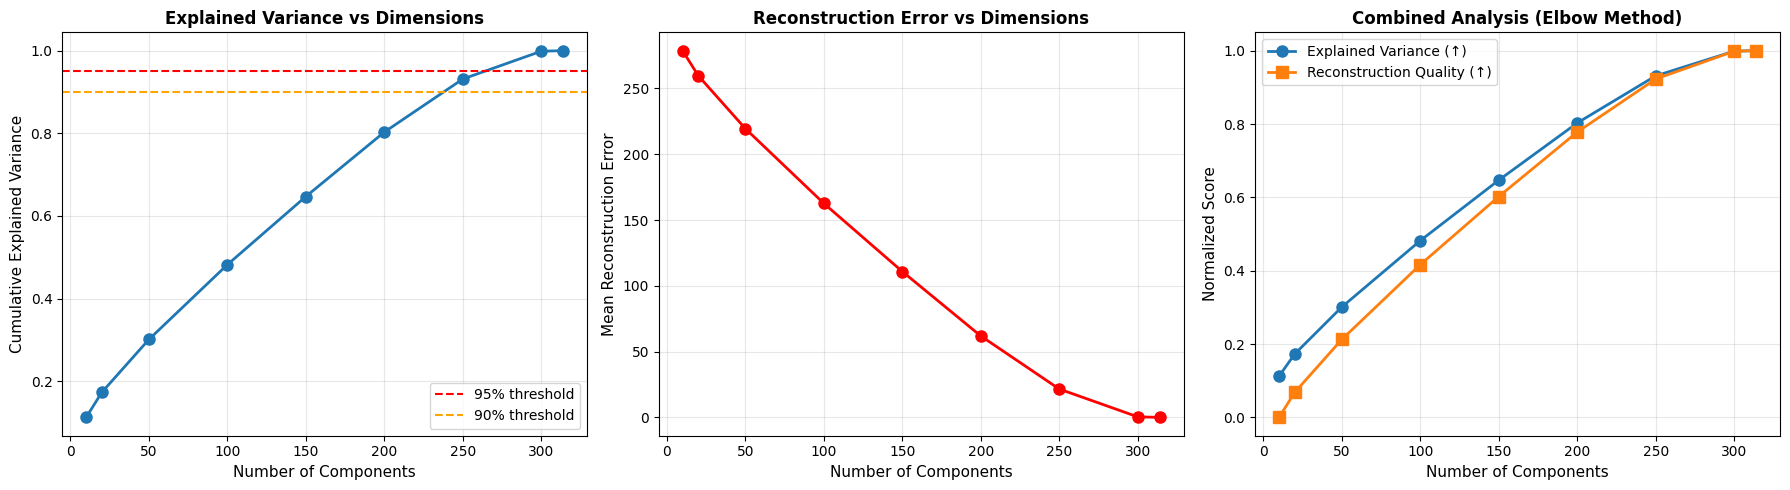


Intrinsic Dimensionality Analysis:
Dimensions for 95% variance: 300
Dimensions for 90% variance: 250

Recommended intrinsic dimensionality: 250 - 300 components


In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Explained Variance vs Dimensions
ax = axes[0]
ax.plot(dimensions_to_test, explained_variances, 'o-', linewidth=2, markersize=8)
ax.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
ax.set_xlabel('Number of Components', fontsize=11)
ax.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax.set_title('Explained Variance vs Dimensions', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Reconstruction Error vs Dimensions
ax = axes[1]
ax.plot(dimensions_to_test, reconstruction_errors, 'o-', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Number of Components', fontsize=11)
ax.set_ylabel('Mean Reconstruction Error', fontsize=11)
ax.set_title('Reconstruction Error vs Dimensions', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Elbow method (normalized)
ax = axes[2]
norm_var = np.array(explained_variances)
norm_err = 1 - (np.array(reconstruction_errors) - min(reconstruction_errors)) / (max(reconstruction_errors) - min(reconstruction_errors))
ax.plot(dimensions_to_test, norm_var, 'o-', label='Explained Variance (↑)', linewidth=2, markersize=8)
ax.plot(dimensions_to_test, norm_err, 's-', label='Reconstruction Quality (↑)', linewidth=2, markersize=8)
ax.set_xlabel('Number of Components', fontsize=11)
ax.set_ylabel('Normalized Score', fontsize=11)
ax.set_title('Combined Analysis (Elbow Method)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Intrinsic Dimensionality Analysis:")
print("=" * 60)

# Find dimension for 95% variance
idx_95 = np.argmax(np.array(explained_variances) >= 0.95)
if explained_variances[idx_95] >= 0.95:
    dim_95 = dimensions_to_test[idx_95]
    print(f"Dimensions for 95% variance: {dim_95}")
else:
    print(f"95% variance not reached (max: {max(explained_variances)*100:.2f}%)")

idx_90 = np.argmax(np.array(explained_variances) >= 0.90)
if explained_variances[idx_90] >= 0.90:
    dim_90 = dimensions_to_test[idx_90]
    print(f"Dimensions for 90% variance: {dim_90}")
else:
    print(f"90% variance not reached")


print(f"\nRecommended intrinsic dimensionality: {dim_90} - {dim_95} components")


In [54]:
# Use the optimal dimensionality
optimal_dim = dim_90
print(f"\n{'='*60}")
print(f"Retraining Classifiers with {optimal_dim} PCA Components")
print(f"{'='*60}")

pca_optimal = PCA(n_components=optimal_dim, random_state=42)
X_train_reduced = pca_optimal.fit_transform(X_train_fused)
X_val_reduced = pca_optimal.transform(X_val_fused)
X_test_reduced = pca_optimal.transform(X_test_fused)

X_trainval_reduced = np.vstack([X_train_reduced, X_val_reduced])

print(f"Original features: {X_train_fused.shape[1]}")
print(f"Reduced features: {X_train_reduced.shape[1]}")
print(f"Variance retained: {np.sum(pca_optimal.explained_variance_ratio_)*100:.2f}%")



Retraining Classifiers with 250 PCA Components
Original features: 314
Reduced features: 250
Variance retained: 93.13%


In [55]:
# Train all classifiers with reduced features
reduced_results = []

print("\n1. Logistic Regression...")
lr_reduced = LogisticRegression(solver='lbfgs', max_iter=3000, C=0.01, random_state=42)
t0 = time.perf_counter()
lr_reduced.fit(X_trainval_reduced, y_trainval)
t1 = time.perf_counter()
lr_test_acc = accuracy_score(y_test_enc, lr_reduced.predict(X_test_reduced))
reduced_results.append({
    'Classifier': 'Logistic Regression',
    'Test Accuracy': lr_test_acc,
    'Training Time (s)': t1 - t0
})
print(f"   Accuracy: {lr_test_acc:.4f}, Time: {t1-t0:.3f}s")

print("\n2. Logistic Regression + Poly...")
lr_poly_reduced = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=5000, C=0.01, random_state=42))
])
t0 = time.perf_counter()
lr_poly_reduced.fit(X_trainval_reduced, y_trainval)
t1 = time.perf_counter()
lr_poly_test_acc = accuracy_score(y_test_enc, lr_poly_reduced.predict(X_test_reduced))
reduced_results.append({
    'Classifier': 'LogReg + Polynomial',
    'Test Accuracy': lr_poly_test_acc,
    'Training Time (s)': t1 - t0
})
print(f"   Accuracy: {lr_poly_test_acc:.4f}, Time: {t1-t0:.3f}s")

print("\n3. Linear SVM...")
svm_reduced = LinearSVC(C=0.001, max_iter=20000, dual='auto', random_state=42)
t0 = time.perf_counter()
svm_reduced.fit(X_trainval_reduced, y_trainval)
t1 = time.perf_counter()
svm_test_acc = accuracy_score(y_test_enc, svm_reduced.predict(X_test_reduced))
reduced_results.append({
    'Classifier': 'Linear SVM',
    'Test Accuracy': svm_test_acc,
    'Training Time (s)': t1 - t0
})
print(f"   Accuracy: {svm_test_acc:.4f}, Time: {t1-t0:.3f}s")

print("\n4. RBF SVM...")
svm_rbf_reduced = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
t0 = time.perf_counter()
svm_rbf_reduced.fit(X_trainval_reduced, y_trainval)
t1 = time.perf_counter()
svm_rbf_test_acc = accuracy_score(y_test_enc, svm_rbf_reduced.predict(X_test_reduced))
reduced_results.append({
    'Classifier': 'RBF SVM',
    'Test Accuracy': svm_rbf_test_acc,
    'Training Time (s)': t1 - t0
})
print(f"   Accuracy: {svm_rbf_test_acc:.4f}, Time: {t1-t0:.3f}s")

print("\n5. k-NN...")
knn_reduced = KNeighborsClassifier(n_neighbors=40, weights='uniform')
t0 = time.perf_counter()
knn_reduced.fit(X_trainval_reduced, y_trainval)
t1 = time.perf_counter()
knn_test_acc = accuracy_score(y_test_enc, knn_reduced.predict(X_test_reduced))
reduced_results.append({
    'Classifier': 'k-NN',
    'Test Accuracy': knn_test_acc,
    'Training Time (s)': t1 - t0
})
print(f"   Accuracy: {knn_test_acc:.4f}, Time: {t1-t0:.3f}s")

print("\n6. Naive Bayes...")
nb_reduced = GaussianNB(var_smoothing=0.01)
t0 = time.perf_counter()
nb_reduced.fit(X_trainval_reduced, y_trainval)
t1 = time.perf_counter()
nb_test_acc = accuracy_score(y_test_enc, nb_reduced.predict(X_test_reduced))
reduced_results.append({
    'Classifier': 'Naive Bayes',
    'Test Accuracy': nb_test_acc,
    'Training Time (s)': t1 - t0
})
print(f"   Accuracy: {nb_test_acc:.4f}, Time: {t1-t0:.3f}s")

print("\n7. Random Forest...")
rf_reduced = RandomForestClassifier(n_estimators=300, max_depth=None, 
                                   min_samples_split=2, max_features='log2',
                                   random_state=42, n_jobs=-1)
t0 = time.perf_counter()
rf_reduced.fit(X_trainval_reduced, y_trainval)
t1 = time.perf_counter()
rf_test_acc = accuracy_score(y_test_enc, rf_reduced.predict(X_test_reduced))
reduced_results.append({
    'Classifier': 'Random Forest',
    'Test Accuracy': rf_test_acc,
    'Training Time (s)': t1 - t0
})
print(f"   Accuracy: {rf_test_acc:.4f}, Time: {t1-t0:.3f}s")

reduced_df = pd.DataFrame(reduced_results)
print("\n" + "=" * 60)
print("Results with Reduced Features:")
print("=" * 60)
print(reduced_df.to_string(index=False))



1. Logistic Regression...
   Accuracy: 0.9128, Time: 16.579s

2. Logistic Regression + Poly...
   Accuracy: 0.8966, Time: 106.404s

3. Linear SVM...
   Accuracy: 0.9031, Time: 0.250s

4. RBF SVM...
   Accuracy: 0.9079, Time: 0.731s

5. k-NN...
   Accuracy: 0.8595, Time: 0.002s

6. Naive Bayes...
   Accuracy: 0.8045, Time: 0.008s

7. Random Forest...
   Accuracy: 0.8869, Time: 3.517s

Results with Reduced Features:
         Classifier  Test Accuracy  Training Time (s)
Logistic Regression       0.912763          16.579212
LogReg + Polynomial       0.896607         106.403897
         Linear SVM       0.903069           0.249875
            RBF SVM       0.907916           0.730840
               k-NN       0.859451           0.001625
        Naive Bayes       0.804523           0.008305
      Random Forest       0.886914           3.516688


In [56]:
# Compare with original results from Task 1
# Extract original results from choices_table
original_results = {
    'Logistic Regression': {'acc': 0.9079, 'time': None},
    'LogReg + Polynomial': {'acc': 0.8740, 'time': None},
    'Linear SVM': {'acc': 0.9063, 'time': None},
    'RBF SVM': {'acc': 0.9031, 'time': None},
    'k-NN': {'acc': 0.7738, 'time': None},
    'Naive Bayes': {'acc': 0.8530, 'time': None},
    'Random Forest': {'acc': 0.8449, 'time': None}
}

comparison_data = []
for _, row in reduced_df.iterrows():
    clf_name = row['Classifier']
    reduced_acc = row['Test Accuracy']
    reduced_time = row['Training Time (s)']
    
    if clf_name in original_results:
        orig_acc = original_results[clf_name]['acc']
        acc_change = reduced_acc - orig_acc
        
        comparison_data.append({
            'Classifier': clf_name,
            'Original Acc': orig_acc,
            'Reduced Acc': reduced_acc,
            'Δ Accuracy': acc_change,
            'Reduced Time (s)': reduced_time
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 60)
print(f"Performance Comparison: Original (314-dim) vs Reduced ({optimal_dim}-dim)")
print("=" * 60)
print(comparison_df.to_string(index=False))

print("\n" + "=" * 60)
print("Summary:")
print("=" * 60)
print(f"Feature reduction: 314 → {optimal_dim} ({(1-optimal_dim/314)*100:.1f}% reduction)")
print(f"Variance retained: {np.sum(pca_optimal.explained_variance_ratio_)*100:.2f}%")
print(f"Average accuracy change: {comparison_df['Δ Accuracy'].mean():.4f}")
print(f"Classifiers improved: {(comparison_df['Δ Accuracy'] > 0).sum()} / {len(comparison_df)}")
print(f"Classifiers degraded: {(comparison_df['Δ Accuracy'] < 0).sum()} / {len(comparison_df)}")



Performance Comparison: Original (314-dim) vs Reduced (250-dim)
         Classifier  Original Acc  Reduced Acc  Δ Accuracy  Reduced Time (s)
Logistic Regression        0.9079     0.912763    0.004863         16.579212
LogReg + Polynomial        0.8740     0.896607    0.022607        106.403897
         Linear SVM        0.9063     0.903069   -0.003231          0.249875
            RBF SVM        0.9031     0.907916    0.004816          0.730840
               k-NN        0.7738     0.859451    0.085651          0.001625
        Naive Bayes        0.8530     0.804523   -0.048477          0.008305
      Random Forest        0.8449     0.886914    0.042014          3.516688

Summary:
Feature reduction: 314 → 250 (20.4% reduction)
Variance retained: 93.13%
Average accuracy change: 0.0155
Classifiers improved: 5 / 7
Classifiers degraded: 2 / 7


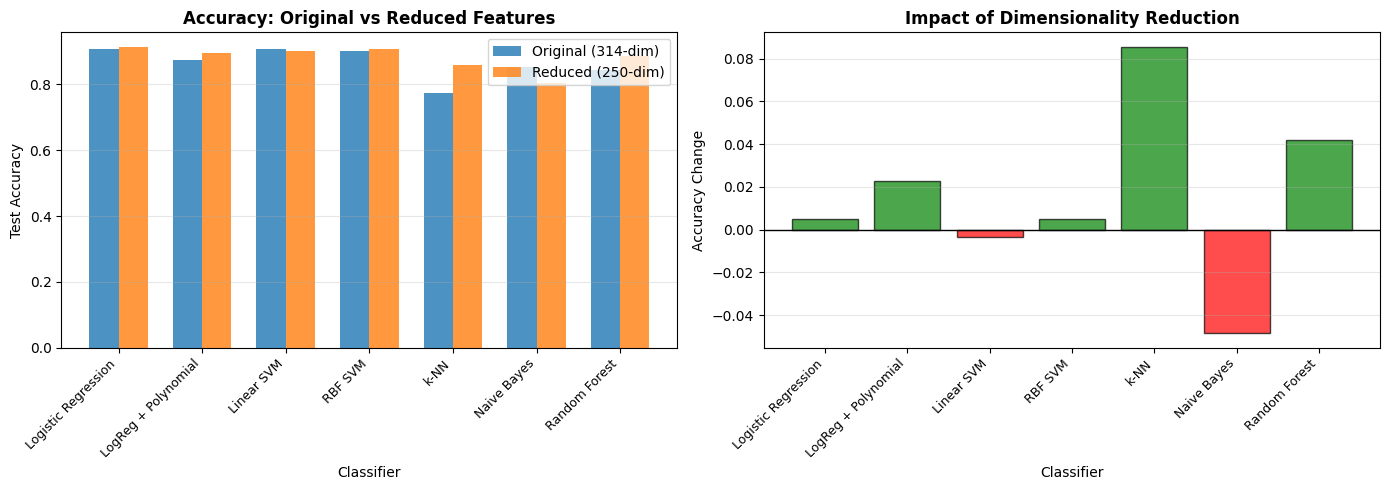

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax = axes[0]
x = np.arange(len(comparison_df))
width = 0.35
ax.bar(x - width/2, comparison_df['Original Acc'], width, label='Original (314-dim)', alpha=0.8)
ax.bar(x + width/2, comparison_df['Reduced Acc'], width, label=f'Reduced ({optimal_dim}-dim)', alpha=0.8)
ax.set_xlabel('Classifier')
ax.set_ylabel('Test Accuracy')
ax.set_title('Accuracy: Original vs Reduced Features', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Classifier'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Accuracy change
ax = axes[1]
colors = ['green' if x > 0 else 'red' for x in comparison_df['Δ Accuracy']]
ax.bar(x, comparison_df['Δ Accuracy'], color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy Change')
ax.set_title('Impact of Dimensionality Reduction', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Classifier'], rotation=45, ha='right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


### 2.2 - Clustering Analysis


In [ ]:
print("=" * 60)
print("K-Means Clustering")
print("=" * 60)

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans.fit_predict(X_train_fused)

print(f"Number of clusters: {n_clusters}")
print(f"Converged in {kmeans.n_iter_} iterations")
print(f"Inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")


K-Means Clustering
Number of clusters: 5
Converged in 31 iterations
Inertia (within-cluster sum of squares): 557103.88


In [ ]:
# External Metrics - compare with true labels
print("\n" + "=" * 60)
print("External Metrics (Ground Truth Comparison)")
print("=" * 60)

# How similarly the clustering groups pairs of points compared to the true labels
ari = adjusted_rand_score(y_train_enc, cluster_labels)
# How much information about the true labels is contained in the cluster labels (normalized)
nmi = normalized_mutual_info_score(y_train_enc, cluster_labels)
# Pairwise precision/recall balance
fmi = fowlkes_mallows_score(y_train_enc, cluster_labels)
# Whether each cluster contains mostly a single class
homogeneity = homogeneity_score(y_train_enc, cluster_labels)
# Whether all members of a class are put into the same cluster
completeness = completeness_score(y_train_enc, cluster_labels)

print(f"Adjusted Rand Index (ARI):       {ari:.4f}  (range: [-1, 1], 1=perfect)")
print(f"Normalized Mutual Info (NMI):    {nmi:.4f}  (range: [0, 1], 1=perfect)")
print(f"Fowlkes-Mallows Index (FMI):     {fmi:.4f}  (range: [0, 1], 1=perfect)")
print(f"Homogeneity:                     {homogeneity:.4f}  (range: [0, 1], 1=perfect)")
print(f"Completeness:                    {completeness:.4f}  (range: [0, 1], 1=perfect)")

external_metrics = {
    'Metric': ['ARI', 'NMI', 'FMI', 'Homogeneity', 'Completeness'],
    'Score': [ari, nmi, fmi, homogeneity, completeness],
    'Description': [
        'Similarity between clusterings',
        'Mutual information normalized',
        'Geometric mean of precision/recall',
        'Each cluster contains one class',
        'All class members in same cluster'
    ]
}
external_df = pd.DataFrame(external_metrics)

# Internal Metrics - no ground truth needed
print("\n" + "=" * 60)
print("Internal Metrics (Cluster Quality)")
print("=" * 60)

# How much closer points are to their own cluster than to other clusters
silhouette = silhouette_score(X_train_fused, cluster_labels)
# How much clusters overlap
davies_bouldin = davies_bouldin_score(X_train_fused, cluster_labels)
# Between-cluster separation relative to within-cluster spread
calinski = calinski_harabasz_score(X_train_fused, cluster_labels)

print(f"Silhouette Score:                {silhouette:.4f}  (range: [-1, 1], 1=best)")
print(f"Davies-Bouldin Index:            {davies_bouldin:.4f}  (lower is better)")
print(f"Calinski-Harabasz Index:         {calinski:.2f}  (higher is better)")

internal_metrics = {
    'Metric': ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'Score': [silhouette, davies_bouldin, calinski],
    'Interpretation': [
        'Avg distance within vs between clusters',
        'Avg similarity of each cluster with worst case',
        'Ratio of between/within cluster dispersion'
    ]
}
internal_df = pd.DataFrame(internal_metrics)

print("\n" + "=" * 60)
print("Metrics Summary:")
print("=" * 60)
print("\nExternal Metrics:")
print(external_df.to_string(index=False))
print("\nInternal Metrics:")
print(internal_df.to_string(index=False))



External Metrics (Ground Truth Comparison)
Adjusted Rand Index (ARI):       0.1621  (range: [-1, 1], 1=perfect)
Normalized Mutual Info (NMI):    0.2414  (range: [0, 1], 1=perfect)
Fowlkes-Mallows Index (FMI):     0.3557  (range: [0, 1], 1=perfect)
Homogeneity:                     0.2283  (range: [0, 1], 1=perfect)
Completeness:                    0.2561  (range: [0, 1], 1=perfect)

Internal Metrics (Cluster Quality)
Silhouette Score:                0.0189  (range: [-1, 1], 1=best)
Davies-Bouldin Index:            6.3846  (lower is better)
Calinski-Harabasz Index:         20.79  (higher is better)

Metrics Summary:

External Metrics:
      Metric    Score                        Description
         ARI 0.162068     Similarity between clusterings
         NMI 0.241412      Mutual information normalized
         FMI 0.355718 Geometric mean of precision/recall
 Homogeneity 0.228307    Each cluster contains one class
Completeness 0.256114  All class members in same cluster

Internal Metric

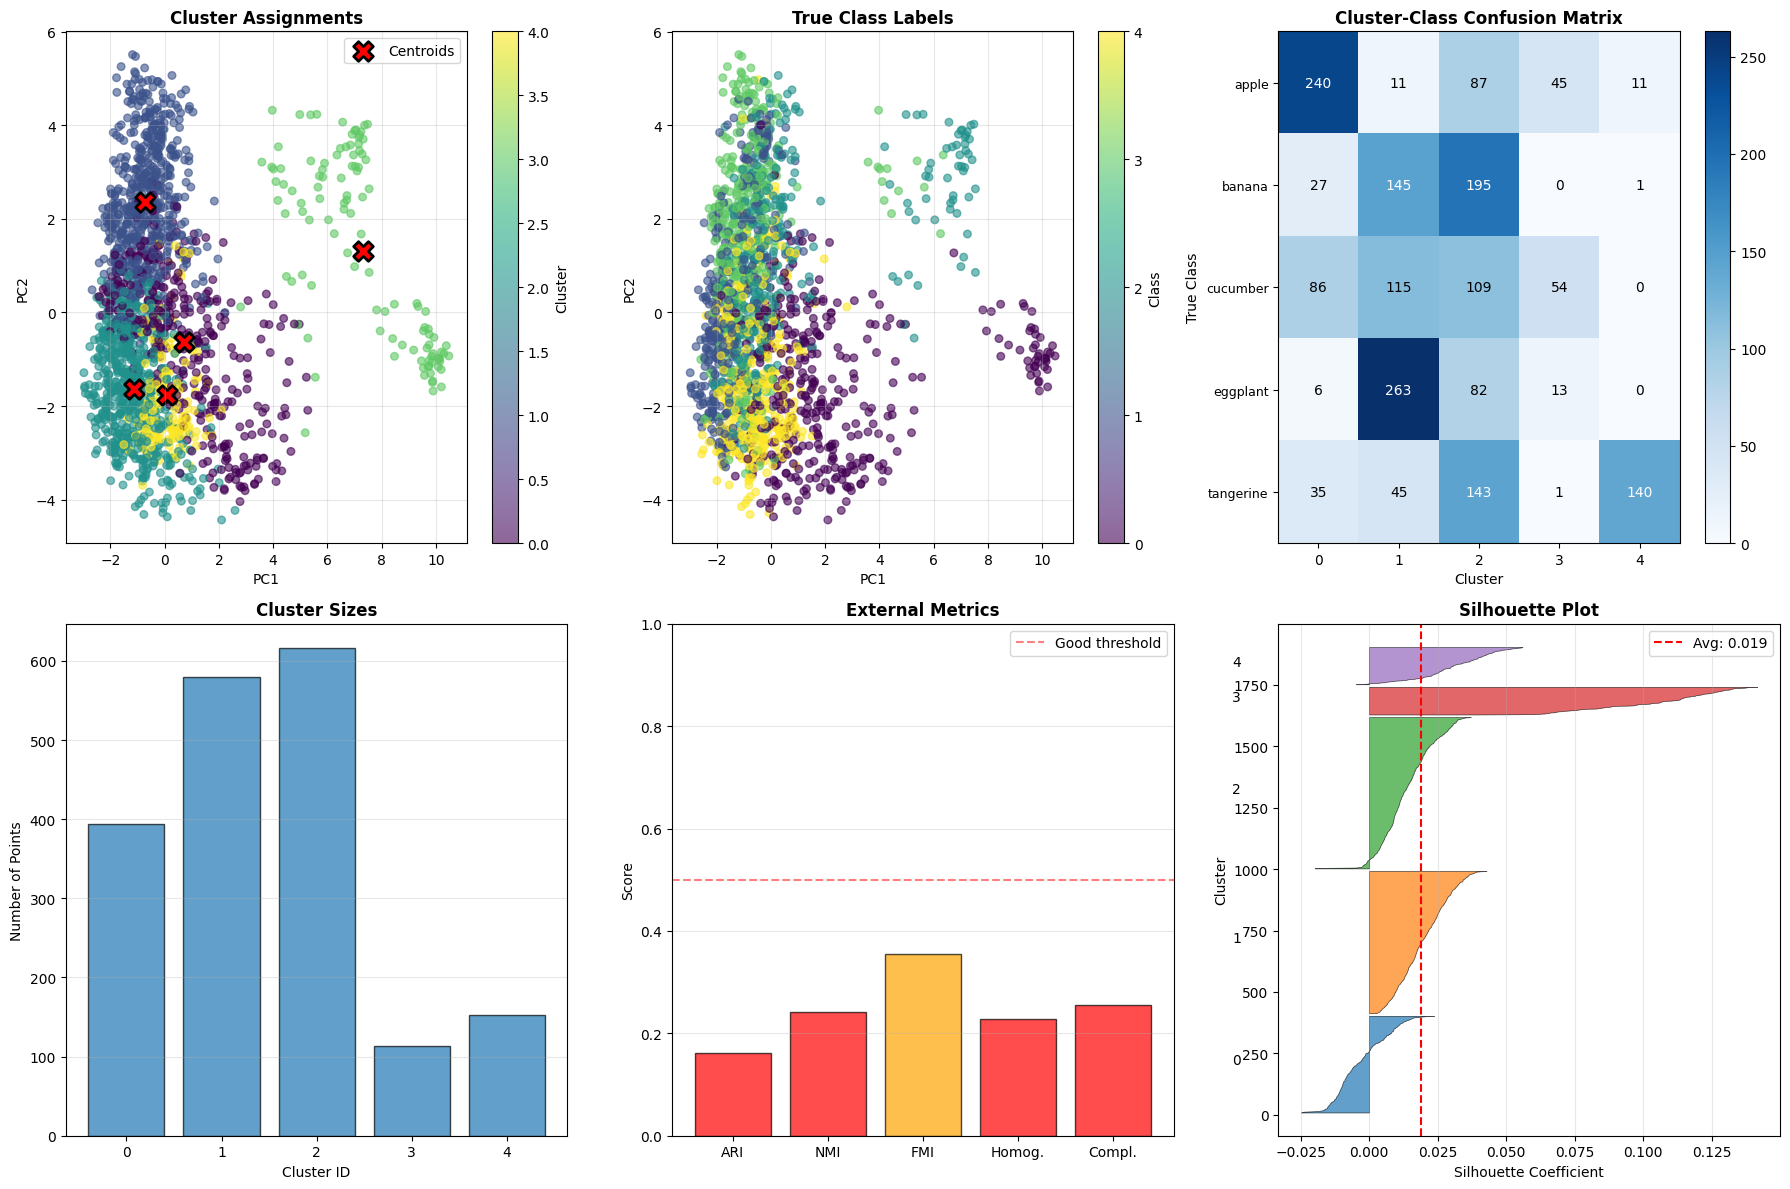

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Cluster assignments in PCA space
ax = axes[0, 0]
scatter = ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=cluster_labels, 
                     cmap='viridis', alpha=0.6, s=30)
ax.scatter(kmeans.cluster_centers_[:, :2] if X_train_fused.shape[1] == 2 else 
           pca_viz.transform(kmeans.cluster_centers_)[:, 0],
           pca_viz.transform(kmeans.cluster_centers_)[:, 1] if X_train_fused.shape[1] != 2 else kmeans.cluster_centers_[:, 1],
           c='red', marker='X', s=200, edgecolors='black', linewidths=2, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Cluster Assignments', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

# True labels in PCA space
ax = axes[0, 1]
scatter = ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_enc, 
                     cmap='viridis', alpha=0.6, s=30)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('True Class Labels', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Class', ticks=range(5))
ax.grid(True, alpha=0.3)

# Confusion matrix between clusters and true labels
ax = axes[0, 2]
cm = conf_mat(y_train_enc, cluster_labels)
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xlabel('Cluster')
ax.set_ylabel('True Class')
ax.set_title('Cluster-Class Confusion Matrix', fontsize=12, fontweight='bold')
ax.set_xticks(range(n_clusters))
ax.set_yticks(range(len(le.classes_)))
ax.set_yticklabels(le.classes_, fontsize=9)
for i in range(len(le.classes_)):
    for j in range(n_clusters):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", 
                      color="white" if cm[i, j] > cm.max()/2 else "black")
plt.colorbar(im, ax=ax)

# Cluster sizes
ax = axes[1, 0]
unique, counts = np.unique(cluster_labels, return_counts=True)
ax.bar(unique, counts, alpha=0.7, edgecolor='black')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Number of Points')
ax.set_title('Cluster Sizes', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Metrics comparison
ax = axes[1, 1]
metrics_names = ['ARI', 'NMI', 'FMI', 'Homog.', 'Compl.']
metrics_values = [ari, nmi, fmi, homogeneity, completeness]
colors_metrics = ['green' if v > 0.5 else 'orange' if v > 0.3 else 'red' for v in metrics_values]
ax.bar(metrics_names, metrics_values, color=colors_metrics, alpha=0.7, edgecolor='black')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Good threshold')
ax.set_ylabel('Score')
ax.set_title('External Metrics', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Silhouette analysis per cluster
ax = axes[1, 2]
silhouette_vals = silhouette_samples(X_train_fused, cluster_labels)
y_lower = 10
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.axvline(x=silhouette, color="red", linestyle="--", label=f'Avg: {silhouette:.3f}')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [61]:
# Analyze cluster-class relationships
print("\n" + "=" * 60)
print("Cluster-Class Mapping Analysis")
print("=" * 60)

# For each cluster, find the dominant class
cluster_class_map = {}
for cluster_id in range(n_clusters):
    cluster_mask = cluster_labels == cluster_id
    classes_in_cluster = y_train_enc[cluster_mask]
    
    # Find most common class
    unique, counts = np.unique(classes_in_cluster, return_counts=True)
    dominant_class_idx = unique[np.argmax(counts)]
    dominant_class_name = le.classes_[dominant_class_idx]
    purity = counts.max() / len(classes_in_cluster)
    
    cluster_class_map[cluster_id] = {
        'dominant_class': dominant_class_name,
        'purity': purity,
        'size': len(classes_in_cluster)
    }
    
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {len(classes_in_cluster)}")
    print(f"  Dominant class: {dominant_class_name} ({purity*100:.1f}% purity)")
    print(f"  Class distribution:")
    for cls_idx, count in zip(unique, counts):
        print(f"    {le.classes_[cls_idx]}: {count} ({count/len(classes_in_cluster)*100:.1f}%)")

# Overall purity
overall_purity = sum([info['size'] * info['purity'] for info in cluster_class_map.values()]) / len(y_train_enc)
print(f"\nOverall Cluster Purity: {overall_purity*100:.2f}%")



Cluster-Class Mapping Analysis

Cluster 0:
  Size: 394
  Dominant class: apple (60.9% purity)
  Class distribution:
    apple: 240 (60.9%)
    banana: 27 (6.9%)
    cucumber: 86 (21.8%)
    eggplant: 6 (1.5%)
    tangerine: 35 (8.9%)

Cluster 1:
  Size: 579
  Dominant class: eggplant (45.4% purity)
  Class distribution:
    apple: 11 (1.9%)
    banana: 145 (25.0%)
    cucumber: 115 (19.9%)
    eggplant: 263 (45.4%)
    tangerine: 45 (7.8%)

Cluster 2:
  Size: 616
  Dominant class: banana (31.7% purity)
  Class distribution:
    apple: 87 (14.1%)
    banana: 195 (31.7%)
    cucumber: 109 (17.7%)
    eggplant: 82 (13.3%)
    tangerine: 143 (23.2%)

Cluster 3:
  Size: 113
  Dominant class: cucumber (47.8% purity)
  Class distribution:
    apple: 45 (39.8%)
    cucumber: 54 (47.8%)
    eggplant: 13 (11.5%)
    tangerine: 1 (0.9%)

Cluster 4:
  Size: 152
  Dominant class: tangerine (92.1% purity)
  Class distribution:
    apple: 11 (7.2%)
    banana: 1 (0.7%)
    tangerine: 140 (92.1%)

Ov

### 2.3 - Clustering-Based Outlier Detection


In [62]:
print("=" * 60)
print("Clustering-Based Outlier Detection Framework")
print("=" * 60)

# Points far from their cluster centroid are outliers
# Compute distance from each point to its assigned cluster centroid

cluster_centers = kmeans.cluster_centers_
distances_to_centroid = np.zeros(len(X_train_fused))

for i, (x, cluster_id) in enumerate(zip(X_train_fused, cluster_labels)):
    centroid = cluster_centers[cluster_id]
    distances_to_centroid[i] = np.linalg.norm(x - centroid)

# Compute z-scores for these distances
z_scores_clustering = (distances_to_centroid - np.mean(distances_to_centroid)) / (np.std(distances_to_centroid) + 1e-10)

# Detect outliers using z-score threshold
z_threshold_clustering = 2
is_outlier_clustering = z_scores_clustering > z_threshold_clustering

n_outliers_clustering = np.sum(is_outlier_clustering)
print(f"\nMethod: Distance to cluster centroid with z-score > {z_threshold_clustering}")
print(f"Detected: {n_outliers_clustering} / {len(X_train_fused)} ({100*n_outliers_clustering/len(X_train_fused):.2f}%)")

print(f"\nDistance Statistics:")
print(f"  Mean: {np.mean(distances_to_centroid):.4f}")
print(f"  Std:  {np.std(distances_to_centroid):.4f}")
print(f"  Min:  {np.min(distances_to_centroid):.4f}")
print(f"  Max:  {np.max(distances_to_centroid):.4f}")


Clustering-Based Outlier Detection Framework

Method: Distance to cluster centroid with z-score > 2
Detected: 53 / 1854 (2.86%)

Distance Statistics:
  Mean: 17.2066
  Std:  2.1028
  Min:  10.5406
  Max:  26.3290


In [63]:
# Compare both outlier detection methods
print("\n" + "=" * 60)
print("Comparison: SVM-Based vs Clustering-Based Outlier Detection")
print("=" * 60)

# Overlap analysis
overlap = np.sum(is_outlier & is_outlier_clustering)
only_svm = np.sum(is_outlier & ~is_outlier_clustering)
only_clustering = np.sum(~is_outlier & is_outlier_clustering)
neither = np.sum(~is_outlier & ~is_outlier_clustering)

print(f"\nVenn Diagram Analysis:")
print(f"  Both methods agree (outlier):     {overlap} ({100*overlap/len(X_train_fused):.2f}%)")
print(f"  Only SVM detected:                {only_svm} ({100*only_svm/len(X_train_fused):.2f}%)")
print(f"  Only Clustering detected:         {only_clustering} ({100*only_clustering/len(X_train_fused):.2f}%)")
print(f"  Both methods agree (normal):      {neither} ({100*neither/len(X_train_fused):.2f}%)")

# Agreement metrics
total_outliers_union = np.sum(is_outlier | is_outlier_clustering)
agreement = (overlap + neither) / len(X_train_fused)
jaccard = overlap / total_outliers_union if total_outliers_union > 0 else 0

print(f"\nAgreement Metrics:")
print(f"  Overall agreement: {agreement*100:.2f}%")
print(f"  Jaccard similarity: {jaccard:.4f}")

# Per-class breakdown
print(f"\nOutliers by Class:")
print(f"{'Class':<12} {'SVM':<8} {'Clustering':<12} {'Both':<8}")
print("-" * 45)
for cls_idx, cls_name in enumerate(le.classes_):
    mask = y_train_enc == cls_idx
    svm_count = np.sum(is_outlier[mask])
    clust_count = np.sum(is_outlier_clustering[mask])
    both_count = np.sum(is_outlier[mask] & is_outlier_clustering[mask])
    print(f"{cls_name:<12} {svm_count:<8} {clust_count:<12} {both_count:<8}")



Comparison: SVM-Based vs Clustering-Based Outlier Detection

Venn Diagram Analysis:
  Both methods agree (outlier):     1 (0.05%)
  Only SVM detected:                50 (2.70%)
  Only Clustering detected:         52 (2.80%)
  Both methods agree (normal):      1751 (94.44%)

Agreement Metrics:
  Overall agreement: 94.50%
  Jaccard similarity: 0.0097

Outliers by Class:
Class        SVM      Clustering   Both    
---------------------------------------------
apple        15       15           0       
banana       4        8            0       
cucumber     8        8            0       
eggplant     13       7            0       
tangerine    11       15           1       


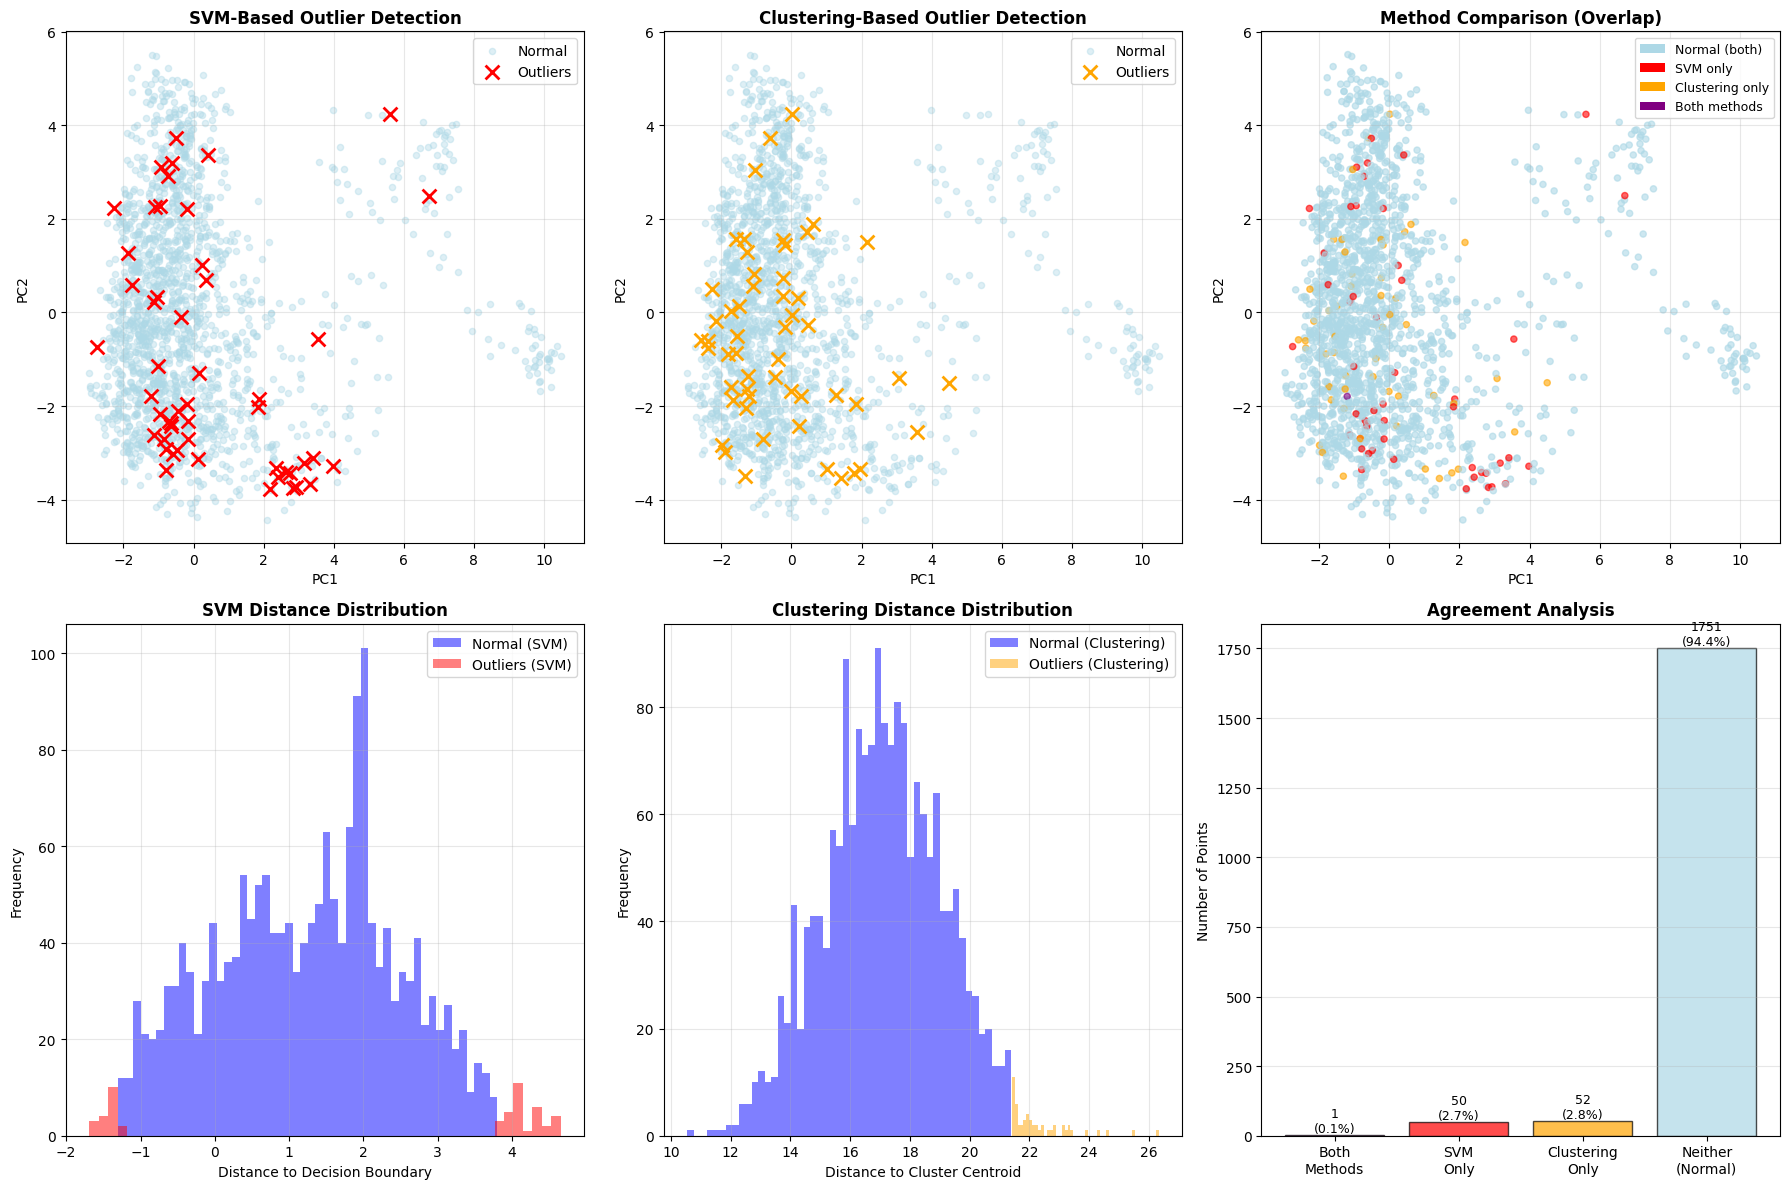

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# SVM-based outliers in PCA space
ax = axes[0, 0]
ax.scatter(X_train_2d[~is_outlier, 0], X_train_2d[~is_outlier, 1], 
          c='lightblue', alpha=0.4, s=20, label='Normal')
ax.scatter(X_train_2d[is_outlier, 0], X_train_2d[is_outlier, 1],
          c='red', marker='x', s=100, linewidths=2, label='Outliers', zorder=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('SVM-Based Outlier Detection', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Clustering-based outliers in PCA space
ax = axes[0, 1]
ax.scatter(X_train_2d[~is_outlier_clustering, 0], X_train_2d[~is_outlier_clustering, 1],
          c='lightblue', alpha=0.4, s=20, label='Normal')
ax.scatter(X_train_2d[is_outlier_clustering, 0], X_train_2d[is_outlier_clustering, 1],
          c='orange', marker='x', s=100, linewidths=2, label='Outliers', zorder=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Clustering-Based Outlier Detection', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Overlap visualization
ax = axes[0, 2]
colors = []
for i in range(len(X_train_fused)):
    if is_outlier[i] and is_outlier_clustering[i]:
        colors.append('purple')  # Both
    elif is_outlier[i]:
        colors.append('red')  # SVM only
    elif is_outlier_clustering[i]:
        colors.append('orange')  # Clustering only
    else:
        colors.append('lightblue')  # Normal

ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=colors, alpha=0.6, s=20)
# Create legend
legend_elements = [
    Patch(facecolor='lightblue', label='Normal (both)'),
    Patch(facecolor='red', label='SVM only'),
    Patch(facecolor='orange', label='Clustering only'),
    Patch(facecolor='purple', label='Both methods')
]
ax.legend(handles=legend_elements, fontsize=9)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Method Comparison (Overlap)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Distance distributions
ax = axes[1, 0]
ax.hist(distances[~is_outlier], bins=50, alpha=0.5, label='Normal (SVM)', color='blue')
ax.hist(distances[is_outlier], bins=50, alpha=0.5, label='Outliers (SVM)', color='red')
ax.set_xlabel('Distance to Decision Boundary')
ax.set_ylabel('Frequency')
ax.set_title('SVM Distance Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Clustering distance distributions
ax = axes[1, 1]
ax.hist(distances_to_centroid[~is_outlier_clustering], bins=50, alpha=0.5, 
        label='Normal (Clustering)', color='blue')
ax.hist(distances_to_centroid[is_outlier_clustering], bins=50, alpha=0.5, 
        label='Outliers (Clustering)', color='orange')
ax.set_xlabel('Distance to Cluster Centroid')
ax.set_ylabel('Frequency')
ax.set_title('Clustering Distance Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Venn diagram-style bar chart
ax = axes[1, 2]
categories = ['Both\nMethods', 'SVM\nOnly', 'Clustering\nOnly', 'Neither\n(Normal)']
counts = [overlap, only_svm, only_clustering, neither]
colors_bar = ['purple', 'red', 'orange', 'lightblue']
bars = ax.bar(categories, counts, color=colors_bar, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Points')
ax.set_title('Agreement Analysis', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
# Add counts on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{count}\n({100*count/len(X_train_fused):.1f}%)',
           ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



Example Outliers Comparison

Sample sizes:
  Both methods: 1
  SVM only: 50
  Clustering only: 52


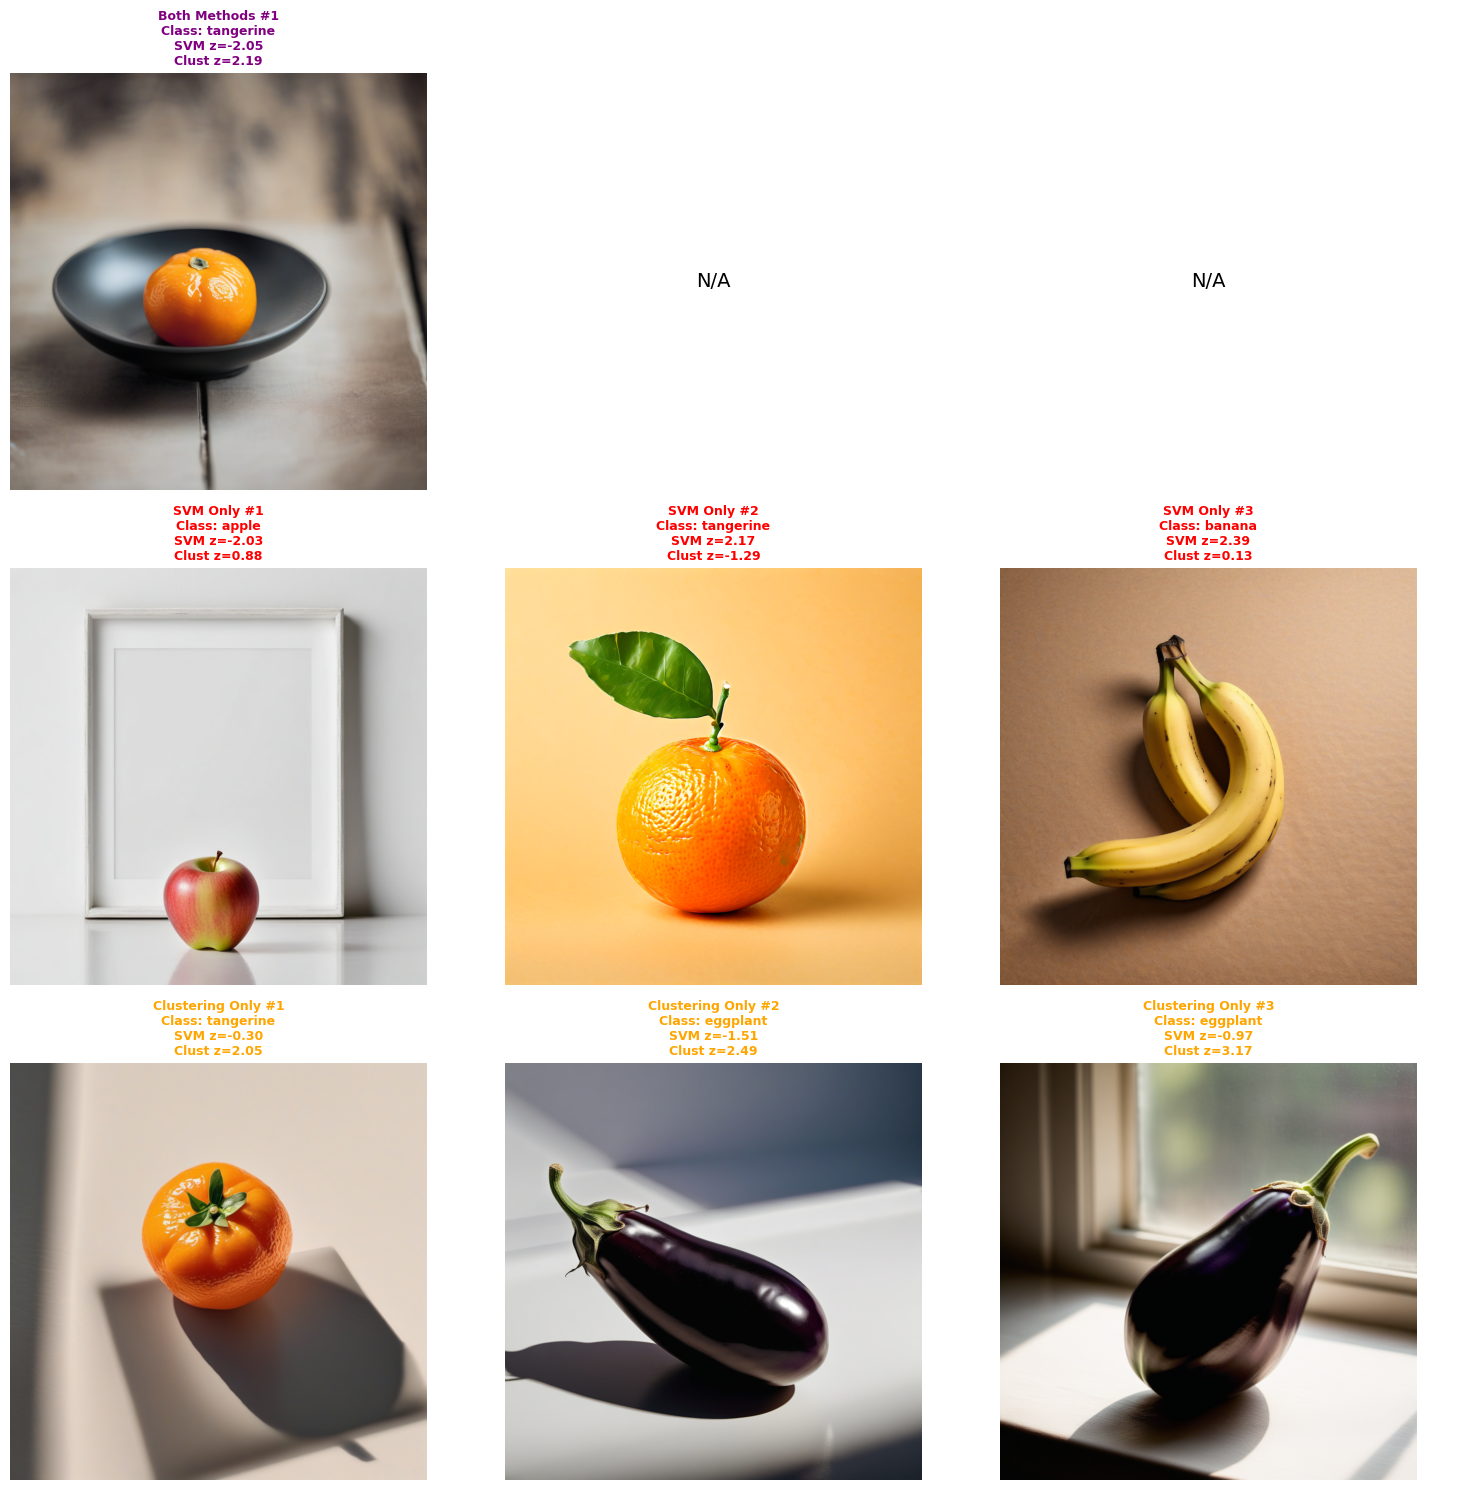


Visual inspection can reveal why each method flagged specific points!


In [65]:
# Display example outliers from each method
print("\n" + "=" * 60)
print("Example Outliers Comparison")
print("=" * 60)

# Find outliers detected by both methods
both_outliers_idx = np.where(is_outlier & is_outlier_clustering)[0]
svm_only_idx = np.where(is_outlier & ~is_outlier_clustering)[0]
clustering_only_idx = np.where(~is_outlier & is_outlier_clustering)[0]

print(f"\nSample sizes:")
print(f"  Both methods: {len(both_outliers_idx)}")
print(f"  SVM only: {len(svm_only_idx)}")
print(f"  Clustering only: {len(clustering_only_idx)}")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for col in range(3):
    ax = axes[0, col]
    if col < len(both_outliers_idx) and col < 3:
        idx = both_outliers_idx[col]
        img = cv2.imread(p_train[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        true_cls = le.classes_[y_train_enc[idx]]
        ax.imshow(img_rgb)
        title = f"Both Methods #{col+1}\n"
        title += f"Class: {true_cls}\n"
        title += f"SVM z={z_scores[idx]:.2f}\n"
        title += f"Clust z={z_scores_clustering[idx]:.2f}"
        ax.set_title(title, fontsize=9, fontweight='bold', color='purple')
    else:
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
    ax.axis('off')

for col in range(3):
    ax = axes[1, col]
    if col < len(svm_only_idx) and col < 3:
        idx = svm_only_idx[col]
        img = cv2.imread(p_train[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        true_cls = le.classes_[y_train_enc[idx]]
        ax.imshow(img_rgb)
        title = f"SVM Only #{col+1}\n"
        title += f"Class: {true_cls}\n"
        title += f"SVM z={z_scores[idx]:.2f}\n"
        title += f"Clust z={z_scores_clustering[idx]:.2f}"
        ax.set_title(title, fontsize=9, fontweight='bold', color='red')
    else:
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
    ax.axis('off')

for col in range(3):
    ax = axes[2, col]
    if col < len(clustering_only_idx) and col < 3:
        idx = clustering_only_idx[col]
        img = cv2.imread(p_train[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        true_cls = le.classes_[y_train_enc[idx]]
        ax.imshow(img_rgb)
        title = f"Clustering Only #{col+1}\n"
        title += f"Class: {true_cls}\n"
        title += f"SVM z={z_scores[idx]:.2f}\n"
        title += f"Clust z={z_scores_clustering[idx]:.2f}"
        ax.set_title(title, fontsize=9, fontweight='bold', color='orange')
    else:
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\nVisual inspection can reveal why each method flagged specific points!")
